# Analysis of County-Level US Presidential Election Winners

## Overview
I was tasked with creating a model to predict which party will win more votes in a county in a United States presidential election based on various demographic features of that county. This model can be used by political parties to identify emerging counties of interest in the lead-up to an election to help guide their decisions on where to allocate advertising, field organizing, and other resources.

I used county-level demographic and presidential election data from the US Census Bureau and MIT Election Data + Science Lab that had been consolidated into a single dataset on Kaggle. The data included information from four presidential elections (2008, 2012, 2016, and 2020), each of which took place in a different national political context and with varying levels of national election turnout.

When building my models, I prioritized maximizing recall (to avoid "false negatives" - counties that we predicted would vote Democratic but actually voted Republican) to minimize the chance that we would lose a county that we expected to win - a result that may cost us a national election. I also prioritized accuracy, because each incorrect prediction in either direction may cost us valuable campaign dollars or electoral votes.

[MODEL DESCRIPTION]

[CONCLUSION]

## Business Problem
Despite winning three of the last four presidential elections, the Democratic Party in the United States faces a perilous political future. A [small number of states](https://www.cnn.com/2022/11/22/politics/2022-preview-2024-presidential-election/index.html) hold the key to swinging any given presidential contest. The near-inverse results of the 2016 and 2020 elections in terms of total electoral college votes despite [small swings in the popular vote margins of these states](https://www.washingtonpost.com/elections/election-results/president-2020/) demonstrates the importance of allocating campaign resources efficiently.

The 2020 election proved that the Democratic Party can return states it had lost in 2016 to its column (Michigan, Wisconsin, Pennsylvania) while simultaneously picking up new states for the first time since the 1990s (Arizona, Georgia). In order to protect these gains, and expand the electoral map to open new opportunities, the party must have an understanding of what factors make a state likely to tip to one party or the other in the coming years.

I chose to conduct my analysis at the county level because while presidential elections are decided at the state level, political parties build operations (such as "get out the vote" efforts and digital advertising campaigns) that target voters at the most granular geographic level possible and need information to guide these decisions. Additionally, these predictions are only meant to be one piece of the puzzle - they can be put in the broader political context of the state and nation as part of the process of developing a comprehensive campaign strategy. 

By building a predictive model to project the winner of presidential elections at the county level, the party can better understand what factors make a given area likely to vote one way or the other in coming elections. It can use this knowledge to guide its investments in emerging fertile areas or to shore up states that are at risk of slipping away.

In [1]:
# Standard Packages
import pandas as pd
import numpy as np

# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt

# Scipy Stats
import scipy.stats as stats

# SKLearn Modules
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier

# XGBoost modules
from xgboost import XGBClassifier
from xgboost import plot_importance

# Suppress future, deprecation, and SettingWithCopy warnings
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None

# make all columns in a df viewable
pd.options.display.max_columns = None
pd.options.display.width = None

# Data

I used [data from the US Census Bureau and MIT Election Data + Science Lab](https://www.kaggle.com/datasets/minhbtnguyen/us-census-for-election-predictions-20002020) that had been consolidated into a single dataset on Kaggle. The data included information from four presidential elections (2008, 2012, 2016, and 2020), each of which took place in a different national political context and with varying levels of national election turnout. The dataset also includes a variety of descriptive demographic statistics such as average income, average age, gender, race, education attainment, and other factors [associated with voting behavior.](https://www.icpsr.umich.edu/web/pages/instructors/setups/voting.html)

In [2]:
# load the dataset
census_data = pd.read_csv('data/county_census_and_election_result.csv')
census_data

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,democrat,green,liberitarian,other,republican,winner
0,2000,1,24566.4,634.6,46.0,46912.7,93.6,6.4,54.0,46.0,8.9,16.8,59.1,11.5,2.3,1.3,77.1,20.0,0.6,1.0,0.1,0.7,0.4,0.0,0.0,97.3,1.5,1.1,96.5,3.5,41.0,51.9,6.4,0.7,58.4,38.4,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,2,33842.9,1080.1,42.4,65021.9,95.3,4.7,50.3,49.7,4.1,18.0,61.1,13.4,1.7,1.6,80.5,2.7,0.6,2.5,0.3,3.6,9.1,0.4,0.2,92.6,2.8,4.6,89.4,10.6,53.1,36.5,8.9,1.5,70.0,25.2,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,4,28331.7,814.7,45.3,52826.7,95.8,4.2,52.1,47.9,6.7,20.8,57.1,11.5,2.0,1.8,84.7,2.4,6.2,1.7,0.2,1.4,2.6,0.7,0.0,86.8,8.3,4.8,79.4,20.6,48.4,43.3,7.5,0.8,58.4,38.3,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,5,22782.6,557.5,46.2,43941.3,92.5,7.5,53.0,47.0,9.5,15.6,60.6,10.9,2.2,1.1,85.7,10.8,0.8,1.2,0.1,0.5,0.7,0.1,0.0,98.0,1.0,1.1,96.8,3.2,38.3,55.7,5.2,0.8,59.1,37.8,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,6,32245.0,1216.3,43.8,61455.3,95.7,4.3,52.0,48.0,6.4,24.5,53.7,10.6,2.4,2.5,70.5,5.4,7.9,2.6,1.3,7.8,0.9,3.5,0.2,70.9,15.2,13.9,65.6,34.4,50.2,40.1,8.5,1.2,61.4,35.1,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7521,2020,55117,26884.0,704.0,50.3,52592.7,95.6,4.4,49.5,50.5,7.3,24.2,57.1,9.4,0.9,1.1,89.7,3.1,1.1,3.4,0.3,1.9,0.1,0.1,0.2,96.4,1.7,1.8,94.4,5.6,50.9,40.7,7.8,0.6,56.3,42.3,1.4,WI,SHEBOYGAN,27101.0,2.0,896.0,403.0,37609.0,1.0
7522,2020,55127,28065.5,846.0,49.0,63315.2,94.9,5.1,49.4,50.6,5.9,26.8,56.6,8.1,0.6,2.0,91.5,0.6,3.3,2.7,0.0,0.1,0.9,0.8,0.0,93.2,2.4,4.4,91.4,8.6,56.1,33.2,9.1,1.7,61.6,37.6,0.8,WI,WALWORTH,22789.0,15.0,641.0,304.0,33851.0,1.0
7523,2020,55133,38557.0,990.6,50.4,80433.1,95.9,4.1,52.8,47.2,7.4,20.0,61.5,9.4,0.3,1.4,91.3,1.4,1.2,3.3,0.1,2.3,0.2,0.2,0.1,94.3,2.1,3.5,93.1,6.9,59.8,26.5,12.9,0.8,60.7,37.3,2.0,WI,WAUKESHA,103906.0,54.0,3023.0,1364.0,159649.0,1.0
7524,2020,55139,25796.1,667.3,45.9,49219.4,93.5,6.5,47.9,52.1,6.7,28.2,50.3,12.4,1.0,1.5,89.7,3.9,0.5,3.8,0.0,1.6,0.3,0.1,0.2,97.7,0.7,1.6,96.1,3.9,51.1,41.3,7.2,0.4,56.9,41.5,1.6,WI,WINNEBAGO,44060.0,38.0,1629.0,509.0,47796.0,1.0


In [3]:
# initial look at data
census_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7526 entries, 0 to 7525
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  7526 non-null   int64  
 1   county_fips           7526 non-null   int64  
 2   inctot                7526 non-null   float64
 3   mortamt1              7526 non-null   float64
 4   avrg_age              7526 non-null   float64
 5   ftotinc               7526 non-null   float64
 6   foodstmp_1_freq       7526 non-null   float64
 7   foodstmp_2_freq       7526 non-null   float64
 8   sex_2_freq            7526 non-null   float64
 9   sex_1_freq            7526 non-null   float64
 10  marst_5_freq          7526 non-null   float64
 11  marst_6_freq          7526 non-null   float64
 12  marst_1_freq          7526 non-null   float64
 13  marst_4_freq          7526 non-null   float64
 14  marst_3_freq          7526 non-null   float64
 15  marst_2_freq         

In [4]:
# initial look at descriptive stats of numeric values
census_data.describe()

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,democrat,green,liberitarian,other,republican,winner
count,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,1.670000e+03,1670.000000,1670.000000,1670.000000,1.670000e+03,1670.000000
mean,2012.369253,27810.761228,28325.447077,884.343848,46.748220,57025.384999,90.560404,9.439596,51.956683,48.043317,6.880880,24.536606,53.739596,11.112437,1.772256,1.957720,80.788759,9.406551,2.728966,1.990194,0.265334,2.807786,0.974409,0.833285,0.208411,89.553734,5.097024,5.349641,85.797250,14.202750,48.947263,40.487164,9.304026,1.261175,58.670648,37.460218,3.869280,1.158984e+05,167.460479,668.785629,4803.562275,8.568574e+04,0.488623
std,4.916645,16197.855610,6973.567827,284.898492,2.641396,13720.562319,4.974988,4.974988,1.708150,1.708106,1.519885,6.726603,7.220689,1.966797,0.782685,0.772832,13.860190,10.505817,3.678845,2.287334,1.323770,3.698773,3.112997,1.698069,0.639464,9.207069,4.557111,5.120796,12.934326,12.934326,6.093376,9.266526,4.175560,0.919959,6.223587,5.988654,1.557713,1.918876e+05,805.370013,2083.527700,10236.284021,9.659596e+04,0.500020
min,2000.000000,1.000000,14165.200000,397.100000,36.100000,31193.400000,58.000000,0.400000,33.400000,38.400000,2.400000,10.100000,25.700000,5.300000,0.000000,0.200000,18.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.400000,0.000000,0.000000,5.700000,0.900000,25.600000,11.100000,2.000000,0.000000,30.700000,20.300000,0.300000,2.474000e+03,0.000000,0.000000,0.000000,2.187000e+03,0.000000
25%,2008.000000,13021.000000,23549.800000,680.125000,45.200000,47305.025000,87.700000,5.800000,51.100000,47.000000,5.800000,19.800000,49.400000,9.700000,1.200000,1.500000,74.400000,2.200000,0.700000,1.000000,0.000000,0.900000,0.200000,0.100000,0.000000,87.000000,2.000000,2.000000,82.300000,5.900000,45.000000,34.025000,6.300000,0.700000,54.900000,33.400000,2.700000,2.843275e+04,0.000000,0.000000,756.250000,3.562700e+04,0.000000
50%,2013.000000,28000.000000,26843.600000,808.200000,46.700000,53615.350000,91.200000,8.800000,52.100000,47.900000,6.800000,23.500000,54.200000,11.100000,1.700000,1.800000,84.300000,5.700000,1.400000,1.400000,0.100000,1.700000,0.300000,0.400000,0.100000,92.600000,3.500000,3.500000,90.500000,9.500000,49.100000,40.500000,8.500000,1.000000,59.200000,36.800000,3.600000,5.305350e+04,0.000000,0.000000,1856.000000,5.448950e+04,0.000000
75%,2017.000000,42000.000000,31579.250000,1019.500000,48.200000,63757.000000,94.200000,12.300000,53.000000,48.900000,7.900000,27.900000,58.800000,12.400000,2.200000,2.300000,91.300000,12.700000,3.200000,2.100000,0.200000,3.200000,0.700000,0.800000,0.200000,95.700000,6.500000,6.700000,94.100000,17.700000,53.000000,47.000000,11.300000,1.500000,63.000000,41.000000,4.700000,1.281622e+05,0.000000,0.000000,4808.250000,1.002938e+05,1.000000
max,2020.000000,56000.000000,68229.100000,2080.900000,59.600000,137573.700000,99.600000,42.000000,61.600000,66.600000,14.700000,54.200000,76.100000,19.500000,6.600000,8.800000,99.000000,66.400000,38.700000,53.000000,23.500000,34.400000,49.400000,23.100000,14.400000,99.900000,29.600000,35.200000,99.100000,94.300000,69.300000,69.700000,

There are a lot of missing rows in some of our columns, but that makes sense since this dataset includes information from many more years than just presidential election years. 

## Data Preparation
We're only interested in rows that have both presidential election results **and** demographic information. Let's start by dropping rows from non-presidential election years (including 2000 and 2004 since this dataset doesn't include voting data from those elections) to see what kind of missingness remains.

In [5]:
# define presidential years and only include records from those years
pres_years = [2008, 2012, 2016, 2020]
pres_df = census_data[census_data['year'].isin(pres_years)]
pres_df

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,democrat,green,liberitarian,other,republican,winner
1528,2008,1000,22523.9,591.8,47.0,44879.5,90.6,9.4,53.4,46.6,9.5,17.4,56.4,12.4,2.6,1.8,77.0,20.0,0.6,1.0,0.1,0.5,0.6,0.1,0.1,97.0,1.9,1.0,96.4,3.6,40.4,53.3,5.9,0.5,54.9,41.6,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1529,2008,1003,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,12.1,63.4,13.2,1.3,1.6,91.1,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,97.1,1.3,1.6,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,AL,BALDWIN,19386.0,0.0,0.0,756.0,61271.0,1.0
1530,2008,1015,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,19.5,54.5,11.5,3.0,2.8,80.5,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,97.3,1.5,1.2,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,AL,CALHOUN,16334.0,0.0,0.0,560.0,32348.0,1.0
1531,2008,1055,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,10.5,13.8,60.9,11.7,1.5,1.6,85.5,11.6,0.0,1.6,0.0,0.7,0.2,0.1,0.2,98.6,0.9,0.5,98.0,2.0,45.3,46.6,7.9,0.2,50.3,46.8,2.9,AL,ETOWAH,13497.0,0.0,0.0,645.0,30595.0,1.0
1532,2008,1073,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,9.5,23.5,50.3,12.3,2.5,1.9,63.1,35.1,0.4,0.7,0.0,0.5,0.1,0.1,0.0,97.5,1.3,1.2,96.6,3.4,47.8,42.0,9.3,0.9,58.5,38.1,3.4,AL,JEFFERSON,166121.0,0.0,0.0,2482.0,149921.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7521,2020,55117,26884.0,704.0,50.3,52592.7,95.6,4.4,49.5,50.5,7.3,24.2,57.1,9.4,0.9,1.1,89.7,3.1,1.1,3.4,0.3,1.9,0.1,0.1,0.2,96.4,1.7,1.8,94.4,5.6,50.9,40.7,7.8,0.6,56.3,42.3,1.4,WI,SHEBOYGAN,27101.0,2.0,896.0,403.0,37609.0,1.0
7522,2020,55127,28065.5,846.0,49.0,63315.2,94.9,5.1,49.4,50.6,5.9,26.8,56.6,8.1,0.6,2.0,91.5,0.6,3.3,2.7,0.0,0.1,0.9,0.8,0.0,93.2,2.4,4.4,91.4,8.6,56.1,33.2,9.1,1.7,61.6,37.6,0.8,WI,WALWORTH,22789.0,15.0,641.0,304.0,33851.0,1.0
7523,2020,55133,38557.0,990.6,50.4,80433.1,95.9,4.1,52.8,47.2,7.4,20.0,61.5,9.4,0.3,1.4,91.3,1.4,1.2,3.3,0.1,2.3,0.2,0.2,0.1,94.3,2.1,3.5,93.1,6.9,59.8,26.5,12.9,0.8,60.7,37.3,2.0,WI,WAUKESHA,103906.0,54.0,3023.0,1364.0,159649.0,1.0
7524,2020,55139,25796.1,667.3,45.9,49219.4,93.5,6.5,47.9,52.1,6.7,28.2,50.3,12.4,1.0,1.5,89.7,3.9,0.5,3.8,0.0,1.6,0.3,0.1,0.2,97.7,0.7,1.6,96.1,3.9,51.1,41.3,7.2,0.4,56.9,41.5,1.6,WI,WINNEBAGO,44060.0,38.0,1629.0,509.0,47796.0,1.0


In [6]:
# check info of data
pres_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1858 entries, 1528 to 7525
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  1858 non-null   int64  
 1   county_fips           1858 non-null   int64  
 2   inctot                1858 non-null   float64
 3   mortamt1              1858 non-null   float64
 4   avrg_age              1858 non-null   float64
 5   ftotinc               1858 non-null   float64
 6   foodstmp_1_freq       1858 non-null   float64
 7   foodstmp_2_freq       1858 non-null   float64
 8   sex_2_freq            1858 non-null   float64
 9   sex_1_freq            1858 non-null   float64
 10  marst_5_freq          1858 non-null   float64
 11  marst_6_freq          1858 non-null   float64
 12  marst_1_freq          1858 non-null   float64
 13  marst_4_freq          1858 non-null   float64
 14  marst_3_freq          1858 non-null   float64
 15  marst_2_freq      

Unfortunately, we still have about 200 missing rows in our election results columns. Because our analysis requires precise adherence to actual election outcomes, there is no imputation strategy that will allow us to fill in these values without substantially diluting the value of our recommendations. We will drop these rows to ensure that we have a complete, accurate set of information for each row.

In [7]:
# drop NAs and reset index
pres_df.dropna(inplace = True)
pres_df.reset_index(drop = True, inplace = True)
pres_df

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,democrat,green,liberitarian,other,republican,winner
0,2008,1003,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,12.1,63.4,13.2,1.3,1.6,91.1,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,97.1,1.3,1.6,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,AL,BALDWIN,19386.0,0.0,0.0,756.0,61271.0,1.0
1,2008,1015,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,19.5,54.5,11.5,3.0,2.8,80.5,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,97.3,1.5,1.2,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,AL,CALHOUN,16334.0,0.0,0.0,560.0,32348.0,1.0
2,2008,1055,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,10.5,13.8,60.9,11.7,1.5,1.6,85.5,11.6,0.0,1.6,0.0,0.7,0.2,0.1,0.2,98.6,0.9,0.5,98.0,2.0,45.3,46.6,7.9,0.2,50.3,46.8,2.9,AL,ETOWAH,13497.0,0.0,0.0,645.0,30595.0,1.0
3,2008,1073,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,9.5,23.5,50.3,12.3,2.5,1.9,63.1,35.1,0.4,0.7,0.0,0.5,0.1,0.1,0.0,97.5,1.3,1.2,96.6,3.4,47.8,42.0,9.3,0.9,58.5,38.1,3.4,AL,JEFFERSON,166121.0,0.0,0.0,2482.0,149921.0,0.0
4,2008,1081,24870.4,725.1,40.6,45575.0,92.4,7.6,52.1,47.9,4.9,32.1,51.2,8.3,1.7,2.0,75.2,21.0,0.3,0.6,0.1,1.7,0.3,0.8,0.2,94.4,4.1,1.5,93.2,6.8,53.3,32.2,10.8,3.7,59.8,36.3,3.8,AL,LEE,21498.0,0.0,0.0,597.0,32230.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665,2020,55105,25993.3,657.3,49.1,54440.5,91.6,8.4,51.3,48.7,7.4,27.4,49.9,13.0,0.4,1.9,89.4,3.3,1.3,4.4,0.1,0.2,0.3,0.4,0.5,96.2,1.1,2.7,96.6,3.4,51.4,40.3,7.4,0.8,53.4,43.2,3.4,WI,ROCK,46658.0,14.0,1094.0,456.0,37138.0,0.0
1666,2020,55117,26884.0,704.0,50.3,52592.7,95.6,4.4,49.5,50.5,7.3,24.2,57.1,9.4,0.9,1.1,89.7,3.1,1.1,3.4,0.3,1.9,0.1,0.1,0.2,96.4,1.7,1.8,94.4,5.6,50.9,40.7,7.8,0.6,56.3,42.3,1.4,WI,SHEBOYGAN,27101.0,2.0,896.0,403.0,37609.0,1.0
1667,2020,55127,28065.5,846.0,49.0,63315.2,94.9,5.1,49.4,50.6,5.9,26.8,56.6,8.1,0.6,2.0,91.5,0.6,3.3,2.7,0.0,0.1,0.9,0.8,0.0,93.2,2.4,4.4,91.4,8.6,56.1,33.2,9.1,1.7,61.6,37.6,0.8,WI,WALWORTH,22789.0,15.0,641.0,304.0,33851.0,1.0
1668,2020,55133,38557.0,990.6,50.4,80433.1,95.9,4.1,52.8,47.2,7.4,20.0,61.5,9.4,0.3,1.4,91.3,1.4,1.2,3.3,0.1,2.3,0.2,0.2,0.1,94.3,2.1,3.5,93.1,6.9,59.8,26.5,12.9,0.8,60.7,37.3,2.0,WI,WAUKESHA,103906.0,54.0,3023.0,1364.0,159649.0,1.0


In [8]:
# inspect cleaned data info
pres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670 entries, 0 to 1669
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  1670 non-null   int64  
 1   county_fips           1670 non-null   int64  
 2   inctot                1670 non-null   float64
 3   mortamt1              1670 non-null   float64
 4   avrg_age              1670 non-null   float64
 5   ftotinc               1670 non-null   float64
 6   foodstmp_1_freq       1670 non-null   float64
 7   foodstmp_2_freq       1670 non-null   float64
 8   sex_2_freq            1670 non-null   float64
 9   sex_1_freq            1670 non-null   float64
 10  marst_5_freq          1670 non-null   float64
 11  marst_6_freq          1670 non-null   float64
 12  marst_1_freq          1670 non-null   float64
 13  marst_4_freq          1670 non-null   float64
 14  marst_3_freq          1670 non-null   float64
 15  marst_2_freq         

In [9]:
# inspect cleaned data descriptive stats
pres_df.describe()

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,democrat,green,liberitarian,other,republican,winner
count,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1.670000e+03,1670.000000,1670.000000,1670.000000,1.670000e+03,1670.000000
mean,2014.194012,28717.220958,28841.084850,906.672635,46.903772,58749.243473,90.251257,9.748743,51.855629,48.144371,6.777066,25.837186,52.495150,11.105329,1.721317,2.062275,78.738683,9.917784,2.978862,3.136048,0.235689,3.035150,0.759401,0.928862,0.272455,88.969461,5.269042,5.761198,85.102335,14.897665,49.909222,38.882335,9.860778,1.347904,58.226347,38.028922,3.745689,1.158984e+05,167.460479,668.785629,4803.562275,8.568574e+04,0.488623
std,4.410969,15595.725527,7295.609512,291.128525,2.787388,14606.621299,4.952513,4.952513,1.830548,1.830548,1.559419,7.176813,7.509596,2.044045,0.766393,0.795502,14.646107,10.614890,3.912003,3.870875,1.090427,3.688328,2.406652,1.840668,0.680919,9.457760,4.631289,5.320845,13.393902,13.393902,5.909867,9.208955,4.384230,0.979554,6.558229,6.335632,1.373302,1.918876e+05,805.370013,2083.527700,10236.284021,9.659596e+04,0.500020
min,2008.000000,1003.000000,14897.300000,421.100000,36.700000,34914.700000,65.600000,0.900000,33.400000,42.000000,2.500000,11.600000,26.800000,5.600000,0.000000,0.500000,18.600000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,44.800000,0.000000,0.000000,6.900000,1.400000,25.600000,13.000000,2.300000,0.000000,30.700000,20.800000,0.800000,2.474000e+03,0.000000,0.000000,0.000000,2.187000e+03,0.000000
25%,2012.000000,13135.000000,23894.650000,698.025000,45.200000,48357.400000,87.300000,6.100000,51.000000,47.100000,5.700000,20.900000,48.000000,9.625000,1.200000,1.500000,71.425000,2.625000,0.725000,1.100000,0.000000,1.000000,0.200000,0.200000,0.100000,86.400000,2.125000,2.200000,81.400000,6.200000,46.100000,32.300000,6.700000,0.700000,54.300000,33.700000,2.800000,2.843275e+04,0.000000,0.000000,756.250000,3.562700e+04,0.000000
50%,2016.000000,29099.000000,27351.850000,828.550000,46.900000,55458.800000,90.900000,9.100000,52.000000,48.000000,6.700000,24.900000,52.800000,11.100000,1.600000,1.950000,82.600000,6.400000,1.600000,1.700000,0.100000,1.900000,0.300000,0.400000,0.200000,92.200000,3.600000,3.900000,89.900000,10.100000,50.000000,38.800000,9.100000,1.100000,58.700000,37.500000,3.500000,5.305350e+04,0.000000,0.000000,1856.000000,5.448950e+04,0.000000
75%,2020.000000,42018.500000,32176.200000,1039.600000,48.400000,66187.150000,93.900000,12.700000,52.900000,49.000000,7.700000,29.400000,57.600000,12.400000,2.200000,2.500000,89.700000,13.300000,3.600000,3.700000,0.200000,3.600000,0.700000,0.900000,0.300000,95.300000,6.900000,7.300000,93.800000,18.600000,54.000000,45.475000,12.100000,1.700000,62.800000,41.700000,4.500000,1.281622e+05,0.000000,0.000000,4808.250000,1.002938e+05,1.000000
max,2020.000000,55139.000000,68229.100000,2064.600000,59.400000,137573.700000,99.100000,34.400000,58.000000,66.600000,14.700000,54.100000,74.800000,19.500000,5.800000,8.500000,99.000000,65.400000,38.700000,53.000000,20.100000,33.700000,42.900000,23.100000,14.400000,99.900000,28.200000,34.600000,98.600000,93.100000,68.600000,69.700

From this initial examination it appears that we will have to drop some columns to avoid issues of multicollinearity. For example, for every row, the values of "sex_2_freq" and "sex_1_freq" will sum to 100%:

In [10]:
# checking that sum of those two columns = 100 for all rows
gender_check = pres_df.loc[pres_df['sex_2_freq'] + pres_df['sex_1_freq'] == 100]
assert gender_check.shape[0] == pres_df.shape[0]

The same goes for each discrete category of demographic information included - foodstamp frequency, gender, marriage status, race, citizenship, language spoken, educational attainment, and employment. Having perfectly (or even near-perfectly) correlated variables such as these in our data will make our model less powerful by artificially inflating its variance. 

In order to avoid multicollinearity, we will drop the column with the highest mean (which means it has the highest average proportion) from each category to serve as the "baseline" for our analysis. We can also drop the year, County FIP Code, state_po, and county_name columns since they will not be used in our analysis for now.

In [11]:
# drop columns
default = ['year',                     # year
          'county_fips',              # unique county identifier
          'foodstmp_1_freq',          # % not on foodstamps
          'sex_2_freq',               # % female
          'marst_1_freq',             # % married spouse present
          'race_1_freq',              # % white
          'ctz_stat_1_freq',          # % natural citizen
          'lang_1_freq',              # % speak english at home
          'educ_attain_2.0_freq',     # % some college or bachelors degree
          'empstat_1.0_freq',         # % employed
          'state_po',                 # state postal abbreviation
          'county_name']

pres_df_binary = pres_df.drop(default, axis = 1)
pres_df_binary.head(2)

,inctot,mortamt1,avrg_age,ftotinc,foodstmp_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_2_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_3.0_freq,empstat_2.0_freq,democrat,green,liberitarian,other,republican,winner
0,27222.4,902.2,48.6,53308.6,5.8,47.5,8.3,12.1,13.2,1.3,1.6,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,1.3,1.6,2.9,39.3,8.4,0.5,43.5,2.4,19386.0,0.0,0.0,756.0,61271.0,1.0
1,20951.6,551.7,47.1,39712.5,10.9,45.2,8.7,19.5,11.5,3.0,2.8,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,1.5,1.2,4.6,52.6,5.0,1.2,41.1,4.5,16334.0,0.0,0.0,560.0,32348.0,1.0


In [12]:
# check that they're gone
assert not any(col in pres_df_binary.columns for col in default)

Additionally, in order to create a model of the relationship between the demographics of each county and the winner, we need to eliminate the actual vote totals for each county from our dataframe. These vote counts are a significant source of potential data leakage in any model, since they would not be known at the time our prediction is made.

In [13]:
# drop columns with vote counts
votecounts = ['democrat',
              'green', 
              'liberitarian',
              'other',
              'republican']

pres_df_binary.drop(votecounts, inplace = True, axis = 1)
pres_df_binary.head(2)

,inctot,mortamt1,avrg_age,ftotinc,foodstmp_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_2_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_3.0_freq,empstat_2.0_freq,winner
0,27222.4,902.2,48.6,53308.6,5.8,47.5,8.3,12.1,13.2,1.3,1.6,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,1.3,1.6,2.9,39.3,8.4,0.5,43.5,2.4,1.0
1,20951.6,551.7,47.1,39712.5,10.9,45.2,8.7,19.5,11.5,3.0,2.8,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,1.5,1.2,4.6,52.6,5.0,1.2,41.1,4.5,1.0


Now that we have a complete dataset, we need to take a look at the descriptive statistics to see if there are any obvious outliers or data entry errors. These column headers are difficult to interpret - let's replace them with their description from the metadata included with the data to make it simpler to understand.

In [14]:
# load descriptions and create a dictionary with original column names and their description
descriptions = pd.read_csv('data/meta_data.csv')
descriptions_dict = dict(zip(descriptions['Column'], descriptions['Description']))
descriptions_dict

{'year': 'Year',
 'county_fips': 'County FIP Code',
 'inctot': 'Average Annual Income of Individuals',
 'mortamt1': 'Average Amount Of Mortgage Payments',
 'avrg_age': 'Average Age',
 'ftotinc': 'Average Annual Total Family Income',
 'foodstmp_1_freq': '% of Individuals Who Did Not Receive Foodstamps',
 'foodstmp_2_freq': '% of Individuals Who Received Foodstamps',
 'sex_2_freq': '% of Females',
 'sex_1_freq': '% of Males',
 'marst_5_freq': '% Widowed',
 'marst_6_freq': '% Never Married',
 'marst_1_freq': '% Married Spouse Present',
 'marst_4_freq': '% Divorced',
 'marst_3_freq': '% Seperated',
 'marst_2_freq': '% Married Spouse Absent',
 'race_1_freq': '% White',
 'race_2_freq': '% Black/African American',
 'race_7_freq': '% Other Race',
 'race_8_freq': '% Two major Races',
 'race_5_freq': '% Japanese',
 'race_6_freq': '% Other Asian',
 'race_3_freq': '% American Indian or Alaska Native',
 'race_4_freq': '% Chinese',
 'race_9_freq': '% Three or More Races',
 'ctz_stat_1_freq': '% Citi

In [15]:
# rename columns using descriptions
pres_df_binary.rename(columns=descriptions_dict, inplace=True)
pres_df_binary.head(2)

,Average Annual Income of Individuals,Average Amount Of Mortgage Payments,Average Age,Average Annual Total Family Income,% of Individuals Who Received Foodstamps,% of Males,% Widowed,% Never Married,% Divorced,% Seperated,% Married Spouse Absent,% Black/African American,% Other Race,% Two major Races,% Japanese,% Other Asian,% American Indian or Alaska Native,% Chinese,% Three or More Races,% Non-Citizen,% Naturalized Citizen,% Another Language Is Spoken At Home,% High School or Lower Education,% Masters or Professional Certificate,% Doctoral Degree,% Not In The Labor Force,% Unemployed,winner
0,27222.4,902.2,48.6,53308.6,5.8,47.5,8.3,12.1,13.2,1.3,1.6,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,1.3,1.6,2.9,39.3,8.4,0.5,43.5,2.4,1.0
1,20951.6,551.7,47.1,39712.5,10.9,45.2,8.7,19.5,11.5,3.0,2.8,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,1.5,1.2,4.6,52.6,5.0,1.2,41.1,4.5,1.0


In [16]:
# check descriptive stats with more interpretable column names
pres_df_binary.describe()

,Average Annual Income of Individuals,Average Amount Of Mortgage Payments,Average Age,Average Annual Total Family Income,% of Individuals Who Received Foodstamps,% of Males,% Widowed,% Never Married,% Divorced,% Seperated,% Married Spouse Absent,% Black/African American,% Other Race,% Two major Races,% Japanese,% Other Asian,% American Indian or Alaska Native,% Chinese,% Three or More Races,% Non-Citizen,% Naturalized Citizen,% Another Language Is Spoken At Home,% High School or Lower Education,% Masters or Professional Certificate,% Doctoral Degree,% Not In The Labor Force,% Unemployed,winner
count,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000
mean,28841.084850,906.672635,46.903772,58749.243473,9.748743,48.144371,6.777066,25.837186,11.105329,1.721317,2.062275,9.917784,2.978862,3.136048,0.235689,3.035150,0.759401,0.928862,0.272455,5.269042,5.761198,14.897665,38.882335,9.860778,1.347904,38.028922,3.745689,0.488623
std,7295.609512,291.128525,2.787388,14606.621299,4.952513,1.830548,1.559419,7.176813,2.044045,0.766393,0.795502,10.614890,3.912003,3.870875,1.090427,3.688328,2.406652,1.840668,0.680919,4.631289,5.320845,13.393902,9.208955,4.384230,0.979554,6.335632,1.373302,0.500020
min,14897.300000,421.100000,36.700000,34914.700000,0.900000,42.000000,2.500000,11.600000,5.600000,0.000000,0.500000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.400000,13.000000,2.300000,0.000000,20.800000,0.800000,0.000000
25%,23894.650000,698.025000,45.200000,48357.400000,6.100000,47.100000,5.700000,20.900000,9.625000,1.200000,1.500000,2.625000,0.725000,1.100000,0.000000,1.000000,0.200000,0.200000,0.100000,2.125000,2.200000,6.200000,32.300000,6.700000,0.700000,33.700000,2.800000,0.000000
50%,27351.850000,828.550000,46.900000,55458.800000,9.100000,48.000000,6.700000,24.900000,11.100000,1.600000,1.950000,6.400000,1.600000,1.700000,0.100000,1.900000,0.300000,0.400000,0.200000,3.600000,3.900000,10.100000,38.800000,9.100000,1.100000,37.500000,3.500000,0.000000
75%,32176.200000,1039.600000,48.400000,66187.150000,12.700000,49.000000,7.700000,29.400000,12.400000,2.200000,2.500000,13.300000,3.600000,3.700000,0.200000,3.600000,0.700000,0.900000,0.300000,6.900000,7.300000,18.600000,45.475000,12.100000,1.700000,41.700000,4.500000,1.000000
max,68229.100000,2064.600000,59.400000,137573.700000,34.400000,66.600000,14.700000,54.100000,19.500000,5.800000,8.500000,65.400000,38.700000,53.000000,20.100000,33.700000,42.900000,23.100000,14.400000,28.200000,34.600000,93.100000,69.700000,36.600000,7.500000,67.200000,10.400000,1.000000


From examining the head of the data and the descriptive statistics, there are a couple of observations we can make:
- Our variables are on different orders of magnitude. Average individual and family income are in the 10s of thousands; mortgage payments are in the hundreds of thousands; the remainder of the variables are in the ones or tens. We'll need to scale these variables to close the distance between them.
- There are some potential outliers (such as the county where only 6.9% of people speak English at home, or the county where over 67% of the population is not in the labor force).
- These counties have a diverse set of demographic characteristics along a variety of lines of difference, such as race, marriage status, language spoken at home, and more.
- It doesn't look like we have a class imbalance based on the mean and median values of the binary "winner" column, but we can check that in a moment.

Let's examine the distribution of each column to check for potential outliers and skew:

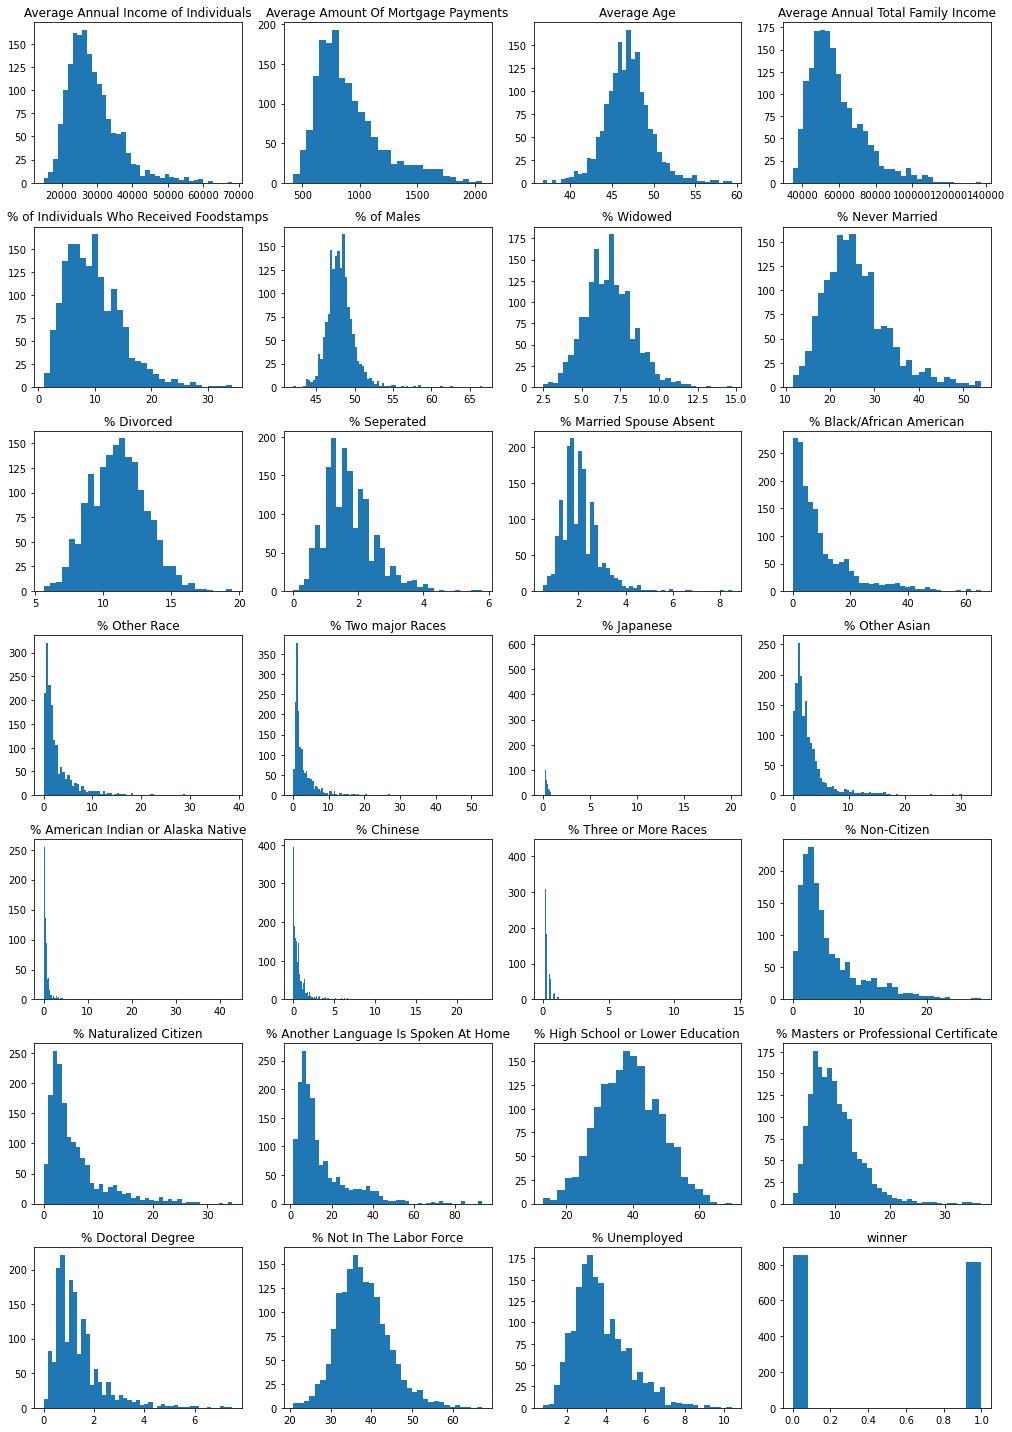

In [17]:
# set up figure for remaining predictor variables in X_third
fig, axes = plt.subplots(nrows=(pres_df_binary.shape[1] // 4), ncols=4, figsize=(14,20))

# for each col in pres_df_binary, plot distribution
for col, ax in zip(pres_df_binary, axes.flatten()):
    ax.hist(pres_df_binary[col], bins='auto')
    ax.set_title(col)
    
fig.tight_layout()

It looks like most of our  variables are either normally distributed or skewed to the right. We can also see that we do not have a substantial class imbalance - the number of counties won by the Democrat (0) and Republican (1) are nearly equal. 

When the time comes to build our model, we'll need to scale and/or transform these columns to bring the orders of magnitude into line and ensure that the distributions are as close to normal as possible.

In [18]:
# checking skew
skew_dict = {col: pres_df_binary[col].skew() for col in pres_df_binary.columns}
sorted(skew_dict.items(), key = lambda x: x[1], reverse = True)

[('% Japanese', 14.225645376417823),
 ('% Three or More Races', 12.958995759654524),
 ('% American Indian or Alaska Native', 12.27393163370858),
 ('% Chinese', 6.117955414893402),
 ('% Two major Races', 4.431729634988505),
 ('% Other Asian', 3.528662241008241),
 ('% Other Race', 3.3196618422536543),
 ('% Another Language Is Spoken At Home', 2.1372927643249713),
 ('% Doctoral Degree', 2.0947227321666024),
 ('% Black/African American', 1.9984005385580035),
 ('% Naturalized Citizen', 1.957434023575899),
 ('% of Males', 1.8348877524676177),
 ('% Married Spouse Absent', 1.7166976573230215),
 ('% Non-Citizen', 1.6925120055089615),
 ('% Masters or Professional Certificate', 1.5473773140107256),
 ('Average Annual Income of Individuals', 1.3717823754930822),
 ('Average Annual Total Family Income', 1.2381474444602085),
 ('Average Amount Of Mortgage Payments', 1.1783968298185061),
 ('% of Individuals Who Received Foodstamps', 0.9988343531328995),
 ('% Unemployed', 0.9564741625539154),
 ('% Never 

It also appears that our classes are pretty balanced:

In [19]:
pres_df_binary['winner'].value_counts(normalize = True)

0.0    0.511377
1.0    0.488623
Name: winner, dtype: float64

That's close to a 50/50 split. It also means that for a naive model that just predicts the majority class every time, we would expect an accuracy of about 51%.

Next, also check to see what correlations exist among our features with a heatmap.

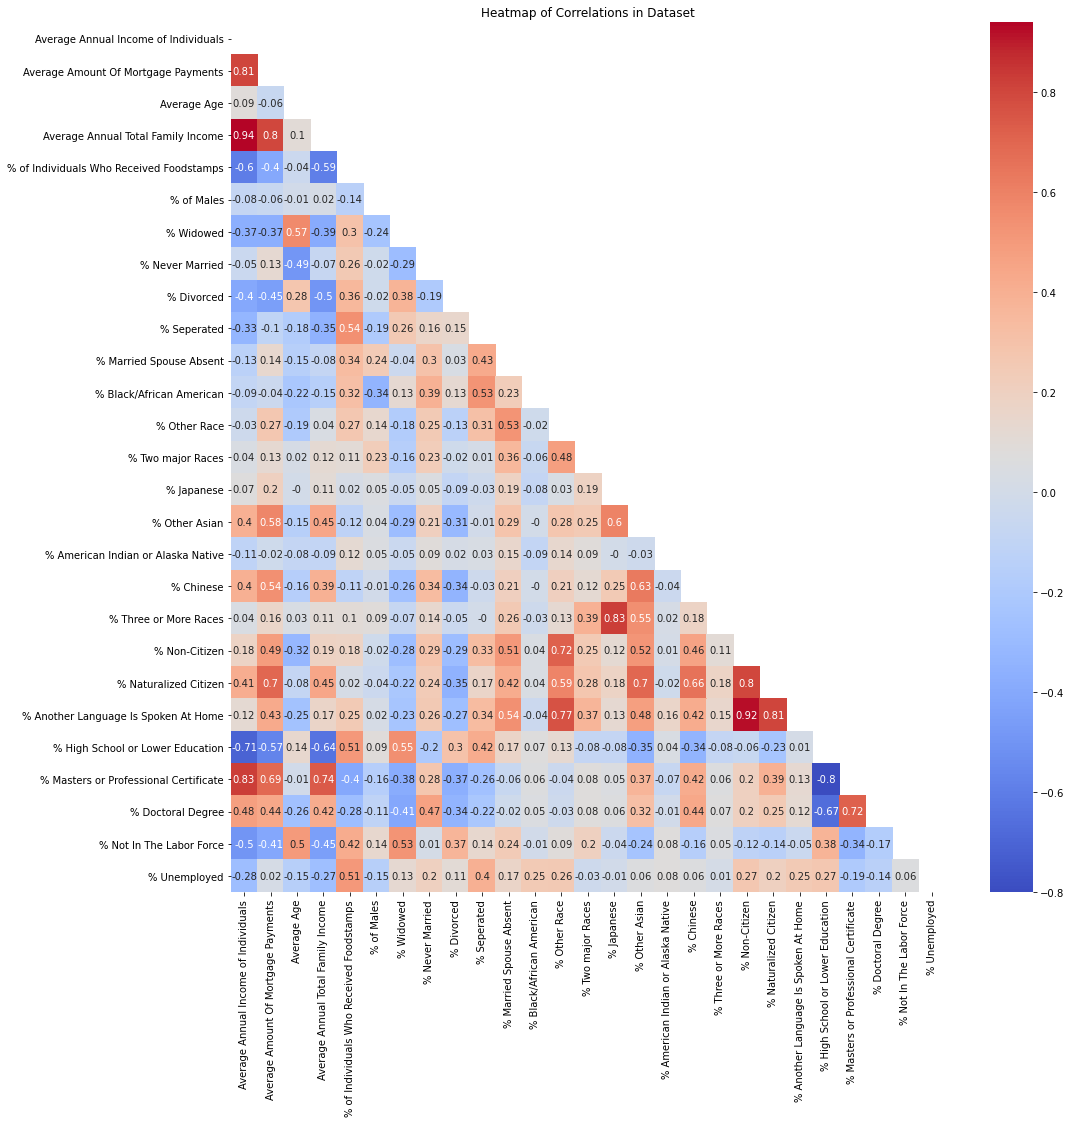

In [20]:
# instantiate figure
fig, ax = plt.subplots(figsize=(16, 16))

# set up correlation matrix
corr = round(pres_df_binary.drop('winner', axis = 1).corr(), 2)

# create a mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# plot figure
sns.heatmap(corr, cmap = 'coolwarm', annot = True, mask = mask)

# Customize the plot appearance
ax.set_title("Heatmap of Correlations in Dataset");

plt.show()

There are some notable correlations between categories (such as % Masters or Professional Certificate and Average Annual Income of Individuals, or % Another Language Is Spoken At Home and % Non-Citizen), and a relatively high degree of correlation among variables in the same category. However, for now, we can hold off on removing any more columns from our dataset until we have a baseline model to evaluate and iterate on.

## Baseline Model: Logistic Regression
Let's begin by creating a baseline logistic regression model without transforming any of our features. We'll start by splitting our data into train and test sets, with 25% of our rows set aside as a test set for evaluation. That will leave around 1200 rows for training our model, while preserving 400 to test its performance on unseen data to help us avoid overfitting and underfitting.

In [21]:
# separate X and y
X_full = pres_df_binary.drop('winner', axis = 1)
y_full = pres_df_binary['winner']

In [22]:
# split into train and test sets with a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, 
                                                    test_size = .25, 
                                                    random_state = 270)

In [23]:
# examine head of feature df
X_train.head()

,Average Annual Income of Individuals,Average Amount Of Mortgage Payments,Average Age,Average Annual Total Family Income,% of Individuals Who Received Foodstamps,% of Males,% Widowed,% Never Married,% Divorced,% Seperated,% Married Spouse Absent,% Black/African American,% Other Race,% Two major Races,% Japanese,% Other Asian,% American Indian or Alaska Native,% Chinese,% Three or More Races,% Non-Citizen,% Naturalized Citizen,% Another Language Is Spoken At Home,% High School or Lower Education,% Masters or Professional Certificate,% Doctoral Degree,% Not In The Labor Force,% Unemployed
1292,35446.8,1048.7,49.0,70306.8,9.9,47.9,7.1,31.1,10.5,1.0,2.1,10.7,5.1,6.6,0.1,4.5,0.2,0.6,0.5,6.0,10.7,21.2,33.9,15.9,2.0,38.6,3.6
228,28553.2,703.6,47.7,56406.1,4.1,48.6,7.8,20.0,11.9,1.5,1.5,0.9,0.2,1.1,0.1,0.1,0.1,0.4,0.0,0.6,2.4,4.1,36.5,11.2,0.6,30.0,3.6
298,21456.8,544.2,49.6,45210.0,6.2,49.9,10.7,22.0,10.5,2.2,2.1,3.0,0.1,0.5,0.0,0.6,0.0,0.0,0.0,0.6,1.0,4.4,62.7,5.4,0.8,41.9,2.4
36,33057.2,1546.5,44.3,64583.2,3.1,49.0,5.8,27.1,10.9,1.9,2.8,4.0,5.9,2.7,0.7,9.6,1.0,1.7,0.2,11.9,14.4,32.3,33.2,10.7,1.9,33.2,4.0
335,26268.5,758.5,44.7,56052.4,6.7,49.5,6.8,15.5,10.7,1.8,2.2,1.7,2.8,1.3,0.0,0.7,0.4,0.2,0.1,5.1,1.6,11.9,52.6,4.1,0.5,34.4,3.0


In [24]:
# 1 means the Republican won, 0 means the Democrat won
y_train.head()

1292    0.0
228     1.0
298     1.0
36      0.0
335     1.0
Name: winner, dtype: float64

In [25]:
# make sure nothing went wrong
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

We'll use a pipeline to minimize the risk of data leakage in our baseline, and use a standard scaler to transform the values to ensure they're all on the same order of magnitude. We'll also use a five fold cross validation to minimize the risk of overfitting on the training data.

In [26]:
# instantiate pipeline
baseline_pipe = Pipeline([('scaler', StandardScaler()),
                  ('lr', LogisticRegression(max_iter = 2000))])

# fit pipeline
baseline_pipe.fit(X_train, y_train)

baseline_scores = cross_val_score(baseline_pipe, X_train, y_train, cv=5, scoring = 'recall')
print("Mean cross-validation score:", baseline_scores.mean())

Mean cross-validation score: 0.8335562549173877


Looks like our model is performing okay for now - about 83% accuracy on our validation folds. Let's see how it performs on test data.

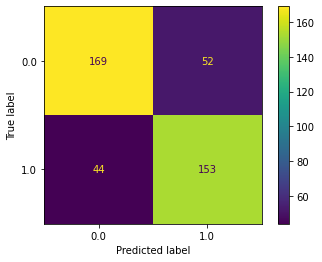

In [27]:
# generate predictions
y_baseline_preds = baseline_pipe.predict(X_test)

# plot confusion matrix
plot_confusion_matrix(baseline_pipe, X_test, y_test);

In [28]:
# print classification report for closer examination
print(classification_report(y_test, y_baseline_preds))

              precision    recall  f1-score   support

         0.0       0.79      0.76      0.78       221
         1.0       0.75      0.78      0.76       197

    accuracy                           0.77       418
   macro avg       0.77      0.77      0.77       418
weighted avg       0.77      0.77      0.77       418



Overall our baseline model performs okay on unseen data (and much better than the 51% we would expect from random predictions), but not nearly at the level we need to guide national campaign-level decision-making. We want to be accurate overall, but in the context of this model, a false negative (where we predicted that a county would vote Democratic but it voted Republican) is a much worse outcome for us than a false positive (where we predicted that a county would vote Republican but it voted Democratic). False positives may cost us money in campaign dollars, but false negatives can cost us elections!

Consequently, we're hoping to minimize our false negatives and maximize our recall. For this baseline, our accuracy and recall are both 77%, meaning only about 77% of our predicted outcomes are accurate and we're only capturing about 77% of the actual number of Republican victories in our data. For subsequent models, we'll try different preprocessing and modeling techniques that may be able to increase these values. Let's make a table to keep track as we go:

In [29]:
evaluation = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Accuracy':[],
                           'Recall':[],
                           'Precision':[],
                           'F1':[]})

lr_prec = precision_score(y_test, y_baseline_preds)
lr_rec = recall_score(y_test, y_baseline_preds)
lr_acc = accuracy_score(y_test, y_baseline_preds)
lr_f1 = f1_score(y_test, y_baseline_preds)

evaluation.loc[0] = ['Baseline Logistic Regression',
                     '-',
                     lr_prec, lr_rec, lr_acc, lr_f1]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.746341,0.77665,0.770335,0.761194


## Model 1: Tuned Logistic Regression
Let's start by tuning the hyperparameters for the logistic regression to try to improve its performance. Since we want to be able to pull the most important features from our model, we'll use an l1 penalty to reduce the weights of less consequential features to effectively 0, and use a GridSearch to test potential regularization hyperparameters and try to maximize the performance on our model on unseen data.

In [30]:
lr_tuned_decision = LogisticRegression(penalty = 'l1', solver = 'liblinear', random_state= 42)
lr_tuned_pipe = Pipeline([('scaler', StandardScaler()),
                    ('model', lr_tuned_decision)])
lr_tuned_params = {'model__C': [.1, 1, 10, 100]}
lr_tuned_cv = GridSearchCV(estimator = lr_tuned_pipe, param_grid = lr_tuned_params, cv = 5, return_train_score=True)
lr_tuned_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(penalty='l1',
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'model__C': [0.1, 1, 10, 100]},
             return_train_score=True)

In [31]:
lr_tuned_results = pd.DataFrame(lr_tuned_cv.cv_results_)
lr_tuned_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.004850,0.000342,0.000976,0.000064,0.1,{'model__C': 0.1},0.832669,0.820717,0.788,0.824,0.812,0.815477,0.015250,4,0.829171,0.825175,0.832335,0.817365,0.835329,0.827875,0.006243
1,0.009646,0.000641,0.001044,0.000083,1,{'model__C': 1},0.844622,0.824701,0.816,0.836,0.824,0.829065,0.010055,2,0.846154,0.842158,0.852295,0.844311,0.848303,0.846644,0.003478
2,0.011614,0.001380,0.001142,0.000088,10,{'model__C': 10},0.844622,0.824701,0.816,0.840,0.824,0.829865,0.010712,1,0.843157,0.843157,0.851297,0.841317,0.845309,0.844848,0.003464
3,0.011801,0.000964,0.001239,0.000241,100,{'model__C': 100},0.844622,0.824701,0.812,0.840,0.824,0.829065,0.011811,2,0.843157,0.843157,0.850299,0.842315,0.846307,0.845047,0.002959


It seems the model performs best on the validation folds with a regularization parameter of 10, so let's see how it performs with that hyperparameter on our test data.

In [32]:
# set the hyperparameters and make predictions on the test set
best_lr_tuned_model = lr_tuned_cv.best_estimator_
y_pred_lr_tuned = best_lr_tuned_model.predict(X_test)

In [33]:
# print the classification report
print(classification_report(y_test, y_pred_lr_tuned))

              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78       221
         1.0       0.74      0.79      0.76       197

    accuracy                           0.77       418
   macro avg       0.77      0.77      0.77       418
weighted avg       0.77      0.77      0.77       418



Our recall increased about 1% from the untuned model, and the accuracy remained about the same. Let's create a table to track these results for ease of examination:

In [34]:
best_lr_tuned_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [35]:
lr_tuned_prec = precision_score(y_test, y_pred_lr_tuned)
lr_tuned_rec = recall_score(y_test, y_pred_lr_tuned)
lr_tuned_acc = accuracy_score(y_test, y_pred_lr_tuned)
lr_tuned_f1 = f1_score(y_test, y_pred_lr_tuned)

evaluation.loc[1] = ['Tuned Logistic Regression',
                     'C = 10',
                     lr_tuned_prec, lr_tuned_rec, lr_tuned_acc, lr_tuned_f1]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.746341,0.776650,0.770335,0.761194
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547


We can also pull the coefficients for the variables to see which have the greatest impact on our predictions:

In [36]:
# create dataframe to show coefficients for top 5 most impactful features
lr_features = pd.DataFrame(zip(X_train.columns, np.transpose(best_lr_tuned_model[1].coef_)), 
                           columns=['features', 'coef'])
lr_features.sort_values('coef').head()

,features,coef
14,% Japanese,[-1.9458870992678063]
7,% Never Married,[-1.836097812041869]
0,Average Annual Income of Individuals,[-1.144096330453189]
23,% Masters or Professional Certificate,[-1.0934325750025453]
21,% Another Language Is Spoken At Home,[-1.0691411489577676]


In [37]:
lr_features.sort_values('coef', ascending = False).head()

,features,coef
3,Average Annual Total Family Income,[2.00973914183606]
25,% Not In The Labor Force,[1.5354645872194852]
17,% Chinese,[0.6481663711226369]
19,% Non-Citizen,[0.558283506739808]
9,% Seperated,[0.2930645352445853]


Since a Republican win is classified as our positive outcome, that means that positive coefficients are indicators that a higher value of that variable is associated with a greater likelihood of a Republican win, while a negative coefficient indicates that a given feature is associated with a greater likelihood of a Democratic win. Interestingly, income appears near the top of both categories - individual income is associated with Democratic victories, while family income is associated with Republican victories. We'll need to do more analysis to determine the importance of these coefficients.

## Model 2: Decision Tree

Let's test a few more baseline models before we hone in on one to tune. We'll try a decision tree next - decision trees are great for complex datasets because it splits the data one feature at a time, which will also help us to identify which features are the most important in making predictions about the partisan outcome of a county. We'll use Gini inpurity to measure information gain because we want to heavily penalize heterogeneity in our leaves.

In [38]:
baseline_tree = DecisionTreeClassifier(criterion = 'gini', random_state = 270)
baseline_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=270)

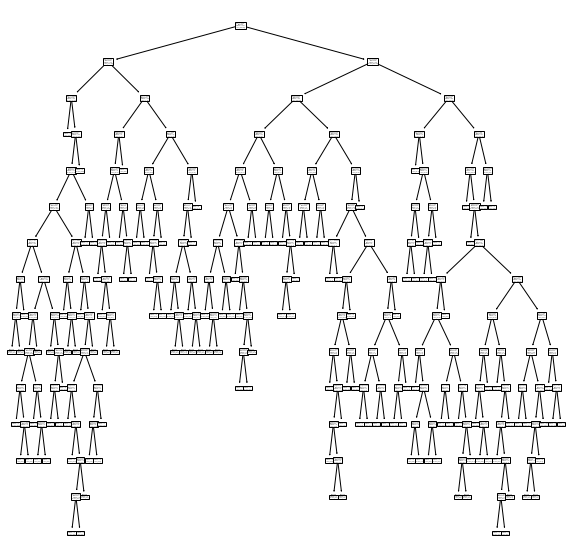

In [39]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(baseline_tree, ax=ax);

With a depth of 15, this model is far too complex and almost certainly overfit. Let's check the scores on the train and test data to see.

In [40]:
y_train_pred = baseline_tree.predict(X_train)
y_test_pred = baseline_tree.predict(X_test)

print('Baseline accuracy: ', baseline_tree.score(X_train, y_train))
print('Test accuracy: ', baseline_tree.score(X_test, y_test))
print('')
print('Baseline recall: ', recall_score(y_train, y_train_pred))
print('Test recall: ', recall_score(y_test, y_test_pred))

Baseline accuracy:  1.0
Test accuracy:  0.7583732057416268

Baseline recall:  1.0
Test recall:  0.7411167512690355


As expected, this model performs much worse on unseen data than on the training data for our key metrics. Let's try pruning it by reducing the max depth to improve our performance on the test set.

In [41]:
# instantiate pipeline
pruned_pipe = Pipeline([('scaler', StandardScaler()),
                        ('tree', DecisionTreeClassifier(criterion = 'gini', random_state = 270))])

# parameter grid
pruned_parameters = {'tree__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

gs_pruned_pipe = GridSearchCV(estimator = pruned_pipe,
                                param_grid = pruned_parameters,
                                cv = 5)

In [42]:
gs_pruned_pipe.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=270))]),
             param_grid={'tree__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [43]:
grid_pruned_results = pd.DataFrame(gs_pruned_pipe.cv_results_)
grid_pruned_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004973,0.000347,0.001183,0.000109,2,{'tree__max_depth': 2},0.756972,0.733068,0.712,0.740,0.684,0.725208,0.025148,9
1,0.005503,0.000098,0.000917,0.000044,3,{'tree__max_depth': 3},0.752988,0.784861,0.740,0.780,0.776,0.766770,0.017286,2
2,0.006685,0.000122,0.000967,0.000081,4,{'tree__max_depth': 4},0.756972,0.752988,0.780,0.780,0.772,0.768392,0.011404,1
3,0.007587,0.000107,0.000892,0.000030,5,{'tree__max_depth': 5},0.760956,0.776892,0.732,0.776,0.748,0.758770,0.017104,4
4,0.008496,0.000042,0.000868,0.000004,6,{'tree__max_depth': 6},0.760956,0.768924,0.764,0.776,0.752,0.764376,0.008010,3
5,0.009624,0.000233,0.000958,0.000116,7,{'tree__max_depth': 7},0.780876,0.752988,0.744,0.780,0.720,0.755573,0.022991,8
6,0.010240,0.000090,0.000880,0.000011,8,{'tree__max_depth': 8},0.792829,0.764940,0.736,0.760,0.732,0.757154,0.022007,6
7,0.010892,0.000199,0.000879,0.000006,9,{'tree__max_depth': 9},0.792829,0.737052,0.748,0.780,0.724,0.756376,0.025995,7
8,0.011376,0.000279,0.000874,0.000003,10,{'tree__max_depth': 10},0.788845,0.752988,0.748,0.792,0.712,0.758767,0.029481,5


It seems like no matter where we prune the tree, there isn't a depth that is going to produce a strong result on unseen data. But somewhat surprisingly, the tree with a max depth of 4 performed the best on our test data. Perhaps we can utilize multiple simpler trees through a random forest model to take advantage of the power of an ensemble learning approach.

## Model 3: Random Forest

In [44]:
# instantiate random forest and pipeline
rf_decision = RandomForestClassifier(n_estimators = 250, random_state= 42)
rf_pipe = Pipeline([('scaler', StandardScaler()),
                    ('model', rf_decision)])
rf_params = {'model__max_depth': np.arange(2,11,1)}
rf_cv = GridSearchCV(estimator = rf_pipe, param_grid = rf_params, cv = 5, return_train_score=True)

In [45]:
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestClassifier(n_estimators=250,
                                                               random_state=42))]),
             param_grid={'model__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
             return_train_score=True)

In [46]:
rf_cv.best_score_

0.8410294820717132

In [47]:
pd.DataFrame(rf_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.236646,0.003669,0.028765,0.033909,2,{'model__max_depth': 2},0.792829,0.816733,0.788,0.792,0.804,0.798712,0.010461,9,0.819181,0.816184,0.825349,0.825349,0.820359,0.821285,0.003587
1,0.269039,0.000677,0.012020,0.000070,3,{'model__max_depth': 3},0.800797,0.832669,0.812,0.812,0.800,0.811493,0.011794,8,0.841159,0.843157,0.849301,0.842315,0.842315,0.843650,0.002897
2,0.304043,0.000592,0.012471,0.000212,4,{'model__max_depth': 4},0.824701,0.852590,0.812,0.824,0.812,0.825058,0.014834,7,0.870130,0.863137,0.884232,0.864271,0.874251,0.871204,0.007659
3,0.338937,0.003052,0.013346,0.000909,5,{'model__max_depth': 5},0.824701,0.856574,0.808,0.832,0.820,0.828255,0.016168,6,0.894106,0.883117,0.901198,0.886228,0.897206,0.892371,0.006748
4,0.372386,0.003732,0.013791,0.000445,6,{'model__max_depth': 6},0.828685,0.844622,0.804,0.840,0.828,0.829061,0.014079,5,0.912088,0.908092,0.918164,0.902196,0.912176,0.910543,0.005269
5,0.398536,0.002474,0.014094,0.000098,7,{'model__max_depth': 7},0.848606,0.852590,0.804,0.844,0.820,0.833839,0.018734,4,0.930070,0.938062,0.935130,0.932136,0.938124,0.934704,0.003201
6,0.420756,0.003613,0.014423,0.000234,8,{'model__max_depth': 8},0.852590,0.860558,0.804,0.856,0.832,0.841029,0.020937,1,0.959041,0.960040,0.957086,0.960080,0.962076,0.959664,0.001623
7,0.436597,0.002193,0.014569,0.000222,9,{'model__max_depth': 9},0.836653,0.860558,0.816,0.852,0.820,0.837042,0.017379,2,0.971029,0.977023,0.976048,0.973054,0.977046,0.974840,0.002400
8,0.447549,0.001758,0.014709,0.000124,10,{'model__max_depth': 10},0.844622,0.852590,0.812,0.852,0.820,0.836242,0.016954,3,0.984016,0.991009,0.988024,0.991018,0.993014,0.989416,0.003135


In [48]:
best_rf_model = RandomForestClassifier(n_estimators = 250, random_state= 42, max_depth = 4)

It looks like for our random forest with a max depth of 8 produces the best score on our validation folds, but based on the scores on the training folds that model looks like it's very overfit. Instead, let's try the model with a max depth of 4, which produces relatively close results for the training and validation folds.

In [49]:
best_rf_model.fit(X_train, y_train)
y_pred_rf = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78       221
         1.0       0.75      0.79      0.77       197

    accuracy                           0.78       418
   macro avg       0.78      0.78      0.78       418
weighted avg       0.78      0.78      0.78       418



We've improved our performance on test data to about 79% for both accuracy and recall. Let's compare the random forest to our original logistic regression model.

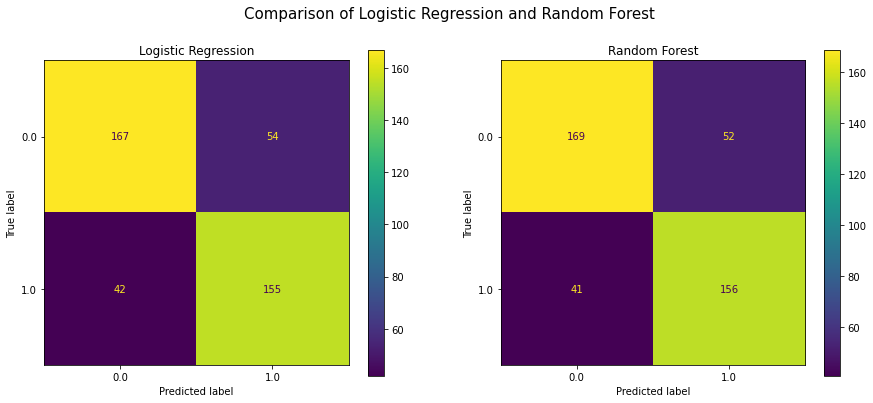

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

fig.suptitle('Comparison of Logistic Regression and Random Forest', fontsize = 15)

axes[0].set_title("Logistic Regression")
axes[1].set_title("Random Forest")

plot_confusion_matrix(best_lr_tuned_model, X_test, y_test, ax=axes[0])
plot_confusion_matrix(best_rf_model, X_test, y_test, ax=axes[1]);

In [51]:
rf_prec = precision_score(y_test, y_pred_rf)
rf_rec = recall_score(y_test, y_pred_rf)
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

evaluation.loc[2] = ['Tuned Random Forest',
                     'Max Depth = 4',
                     rf_prec, rf_rec, rf_acc, rf_f1]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.746341,0.776650,0.770335,0.761194
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547
2,Tuned Random Forest,Max Depth = 4,0.750000,0.791878,0.777512,0.770370


We can see substantial improvements across the board in accuracy for this model compared to the tuned logistic regression - the recall jumped about 5%, and the precision and f1 increased as well. Let's see what the most important features were for this model:

In [52]:
feat_imp = best_rf_model.feature_importances_

feat_imp_series = pd.Series(feat_imp, 
          index = X_train.columns).sort_values(
    ascending = False)

feat_imp_series

% Never Married                             0.239892
% Chinese                                   0.137402
% Other Asian                               0.083430
% Naturalized Citizen                       0.079840
% Masters or Professional Certificate       0.066244
% Doctoral Degree                           0.059755
% Non-Citizen                               0.045241
% Black/African American                    0.041295
% Another Language Is Spoken At Home        0.036401
Average Amount Of Mortgage Payments         0.034467
% Unemployed                                0.026005
Average Age                                 0.021922
% Not In The Labor Force                    0.019398
% of Individuals Who Received Foodstamps    0.015983
% of Males                                  0.013275
% High School or Lower Education            0.011837
Average Annual Income of Individuals        0.008114
Average Annual Total Family Income          0.008110
% Other Race                                0.

## Model 4: XGBoost

In [53]:
xg_params = {'learning_rate': [.01, .1], 'n_estimators': [200,400]}
xg_cv = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', random_state = 270, 
                                               gamma = 10, max_depth = 4, min_child_weight = 4), 
                     scoring='recall', param_grid = xg_params, cv = 5, return_train_score=True)
xg_cv.fit(X_train, y_train);

In [54]:
pd.DataFrame(xg_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.282396,0.024680,0.003225,0.000728,0.01,200,"{'learning_rate': 0.01, 'n_estimators': 200}",0.830645,0.846774,0.813008,0.879032,0.806452,0.835182,0.026057,4,0.882828,0.866667,0.883065,0.870707,0.872727,0.875199,0.006621
1,0.509981,0.033116,0.002375,0.000243,0.01,400,"{'learning_rate': 0.01, 'n_estimators': 400}",0.830645,0.854839,0.821138,0.887097,0.806452,0.840034,0.028309,1,0.886869,0.872727,0.883065,0.874747,0.874747,0.878431,0.005520
2,0.280058,0.044132,0.002094,0.000451,0.1,200,"{'learning_rate': 0.1, 'n_estimators': 200}",0.822581,0.854839,0.821138,0.879032,0.806452,0.836808,0.026372,2,0.882828,0.870707,0.881048,0.870707,0.874747,0.876008,0.005093
3,0.516349,0.064781,0.002550,0.000867,0.1,400,"{'learning_rate': 0.1, 'n_estimators': 400}",0.822581,0.854839,0.821138,0.879032,0.806452,0.836808,0.026372,2,0.882828,0.870707,0.881048,0.870707,0.874747,0.876008,0.005093


In [55]:
xg_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=10, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=270,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
xg_cv.best_score_

0.840034093889326

In [57]:
best_xg_model = xg_cv.best_estimator_
y_pred_xg = best_xg_model.predict(X_test)

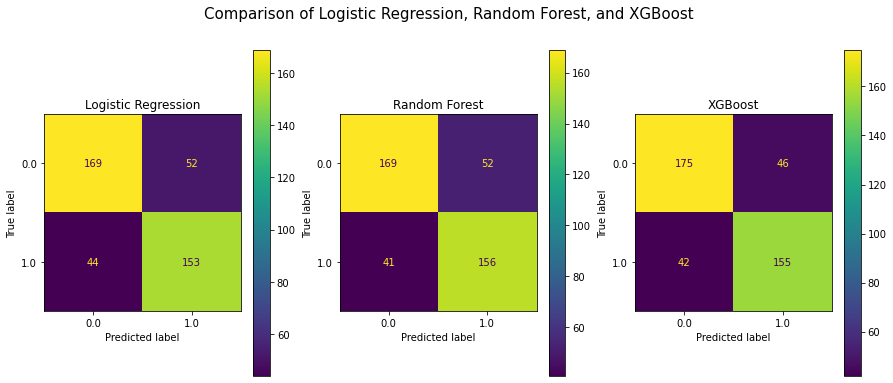

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

fig.suptitle('Comparison of Logistic Regression, Random Forest, and XGBoost', fontsize = 15)

axes[0].set_title("Logistic Regression")
axes[1].set_title("Random Forest")
axes[2].set_title("XGBoost")

plot_confusion_matrix(baseline_pipe, X_test, y_test, ax=axes[0])
plot_confusion_matrix(best_rf_model, X_test, y_test, ax=axes[1])
plot_confusion_matrix(best_xg_model, X_test, y_test, ax=axes[2]);

In [59]:
print(classification_report(y_test, y_pred_xg))

              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80       221
         1.0       0.77      0.79      0.78       197

    accuracy                           0.79       418
   macro avg       0.79      0.79      0.79       418
weighted avg       0.79      0.79      0.79       418



In [60]:
xg_prec = precision_score(y_test, y_pred_xg)
xg_rec = recall_score(y_test, y_pred_xg)
xg_acc = accuracy_score(y_test, y_pred_xg)
xg_f1 = f1_score(y_test, y_pred_xg)

evaluation.loc[3] = ['Tuned XG Boost',
                     'Estimators = 400, Learning Rate = .01',
                     xg_prec, xg_rec, xg_acc, xg_f1]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.746341,0.776650,0.770335,0.761194
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547
2,Tuned Random Forest,Max Depth = 4,0.750000,0.791878,0.777512,0.770370
3,Tuned XG Boost,"Estimators = 400, Learning Rate = .01",0.771144,0.786802,0.789474,0.778894


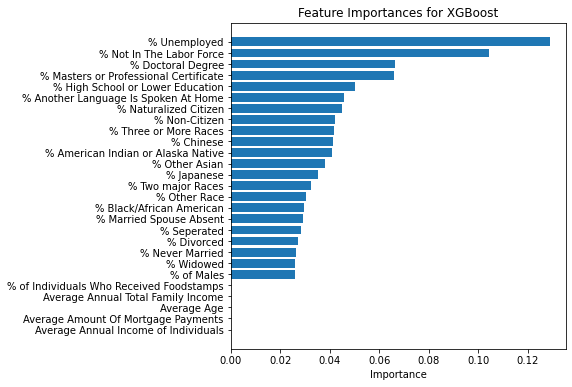

In [61]:
fig, ax = plt.subplots(figsize = (6, 6))
plt.barh(X_train.columns, sorted(best_xg_model.feature_importances_));

ax.set_title('Feature Importances for XGBoost')
ax.set_xlabel('Importance');

## Reducing Dimensionality and Rerunning Models

A lot of our feature categories could be reduced to two columns: a "default" column, and a "not default" column. Let's manually reduce the number of columns in our model to reduce multicollinearity, and try running each of our models again.

In [62]:
pres_df_reduced = census_data[census_data['year'].isin(pres_years)]
pres_df_reduced

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,democrat,green,liberitarian,other,republican,winner
1528,2008,1000,22523.9,591.8,47.0,44879.5,90.6,9.4,53.4,46.6,9.5,17.4,56.4,12.4,2.6,1.8,77.0,20.0,0.6,1.0,0.1,0.5,0.6,0.1,0.1,97.0,1.9,1.0,96.4,3.6,40.4,53.3,5.9,0.5,54.9,41.6,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1529,2008,1003,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,12.1,63.4,13.2,1.3,1.6,91.1,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,97.1,1.3,1.6,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,AL,BALDWIN,19386.0,0.0,0.0,756.0,61271.0,1.0
1530,2008,1015,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,19.5,54.5,11.5,3.0,2.8,80.5,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,97.3,1.5,1.2,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,AL,CALHOUN,16334.0,0.0,0.0,560.0,32348.0,1.0
1531,2008,1055,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,10.5,13.8,60.9,11.7,1.5,1.6,85.5,11.6,0.0,1.6,0.0,0.7,0.2,0.1,0.2,98.6,0.9,0.5,98.0,2.0,45.3,46.6,7.9,0.2,50.3,46.8,2.9,AL,ETOWAH,13497.0,0.0,0.0,645.0,30595.0,1.0
1532,2008,1073,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,9.5,23.5,50.3,12.3,2.5,1.9,63.1,35.1,0.4,0.7,0.0,0.5,0.1,0.1,0.0,97.5,1.3,1.2,96.6,3.4,47.8,42.0,9.3,0.9,58.5,38.1,3.4,AL,JEFFERSON,166121.0,0.0,0.0,2482.0,149921.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7521,2020,55117,26884.0,704.0,50.3,52592.7,95.6,4.4,49.5,50.5,7.3,24.2,57.1,9.4,0.9,1.1,89.7,3.1,1.1,3.4,0.3,1.9,0.1,0.1,0.2,96.4,1.7,1.8,94.4,5.6,50.9,40.7,7.8,0.6,56.3,42.3,1.4,WI,SHEBOYGAN,27101.0,2.0,896.0,403.0,37609.0,1.0
7522,2020,55127,28065.5,846.0,49.0,63315.2,94.9,5.1,49.4,50.6,5.9,26.8,56.6,8.1,0.6,2.0,91.5,0.6,3.3,2.7,0.0,0.1,0.9,0.8,0.0,93.2,2.4,4.4,91.4,8.6,56.1,33.2,9.1,1.7,61.6,37.6,0.8,WI,WALWORTH,22789.0,15.0,641.0,304.0,33851.0,1.0
7523,2020,55133,38557.0,990.6,50.4,80433.1,95.9,4.1,52.8,47.2,7.4,20.0,61.5,9.4,0.3,1.4,91.3,1.4,1.2,3.3,0.1,2.3,0.2,0.2,0.1,94.3,2.1,3.5,93.1,6.9,59.8,26.5,12.9,0.8,60.7,37.3,2.0,WI,WAUKESHA,103906.0,54.0,3023.0,1364.0,159649.0,1.0
7524,2020,55139,25796.1,667.3,45.9,49219.4,93.5,6.5,47.9,52.1,6.7,28.2,50.3,12.4,1.0,1.5,89.7,3.9,0.5,3.8,0.0,1.6,0.3,0.1,0.2,97.7,0.7,1.6,96.1,3.9,51.1,41.3,7.2,0.4,56.9,41.5,1.6,WI,WINNEBAGO,44060.0,38.0,1629.0,509.0,47796.0,1.0


In [63]:
pres_df_reduced.dropna(inplace = True)
pres_df_reduced.reset_index(drop = True, inplace = True)
pres_df_reduced

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,democrat,green,liberitarian,other,republican,winner
0,2008,1003,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,12.1,63.4,13.2,1.3,1.6,91.1,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,97.1,1.3,1.6,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,AL,BALDWIN,19386.0,0.0,0.0,756.0,61271.0,1.0
1,2008,1015,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,19.5,54.5,11.5,3.0,2.8,80.5,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,97.3,1.5,1.2,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,AL,CALHOUN,16334.0,0.0,0.0,560.0,32348.0,1.0
2,2008,1055,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,10.5,13.8,60.9,11.7,1.5,1.6,85.5,11.6,0.0,1.6,0.0,0.7,0.2,0.1,0.2,98.6,0.9,0.5,98.0,2.0,45.3,46.6,7.9,0.2,50.3,46.8,2.9,AL,ETOWAH,13497.0,0.0,0.0,645.0,30595.0,1.0
3,2008,1073,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,9.5,23.5,50.3,12.3,2.5,1.9,63.1,35.1,0.4,0.7,0.0,0.5,0.1,0.1,0.0,97.5,1.3,1.2,96.6,3.4,47.8,42.0,9.3,0.9,58.5,38.1,3.4,AL,JEFFERSON,166121.0,0.0,0.0,2482.0,149921.0,0.0
4,2008,1081,24870.4,725.1,40.6,45575.0,92.4,7.6,52.1,47.9,4.9,32.1,51.2,8.3,1.7,2.0,75.2,21.0,0.3,0.6,0.1,1.7,0.3,0.8,0.2,94.4,4.1,1.5,93.2,6.8,53.3,32.2,10.8,3.7,59.8,36.3,3.8,AL,LEE,21498.0,0.0,0.0,597.0,32230.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665,2020,55105,25993.3,657.3,49.1,54440.5,91.6,8.4,51.3,48.7,7.4,27.4,49.9,13.0,0.4,1.9,89.4,3.3,1.3,4.4,0.1,0.2,0.3,0.4,0.5,96.2,1.1,2.7,96.6,3.4,51.4,40.3,7.4,0.8,53.4,43.2,3.4,WI,ROCK,46658.0,14.0,1094.0,456.0,37138.0,0.0
1666,2020,55117,26884.0,704.0,50.3,52592.7,95.6,4.4,49.5,50.5,7.3,24.2,57.1,9.4,0.9,1.1,89.7,3.1,1.1,3.4,0.3,1.9,0.1,0.1,0.2,96.4,1.7,1.8,94.4,5.6,50.9,40.7,7.8,0.6,56.3,42.3,1.4,WI,SHEBOYGAN,27101.0,2.0,896.0,403.0,37609.0,1.0
1667,2020,55127,28065.5,846.0,49.0,63315.2,94.9,5.1,49.4,50.6,5.9,26.8,56.6,8.1,0.6,2.0,91.5,0.6,3.3,2.7,0.0,0.1,0.9,0.8,0.0,93.2,2.4,4.4,91.4,8.6,56.1,33.2,9.1,1.7,61.6,37.6,0.8,WI,WALWORTH,22789.0,15.0,641.0,304.0,33851.0,1.0
1668,2020,55133,38557.0,990.6,50.4,80433.1,95.9,4.1,52.8,47.2,7.4,20.0,61.5,9.4,0.3,1.4,91.3,1.4,1.2,3.3,0.1,2.3,0.2,0.2,0.1,94.3,2.1,3.5,93.1,6.9,59.8,26.5,12.9,0.8,60.7,37.3,2.0,WI,WAUKESHA,103906.0,54.0,3023.0,1364.0,159649.0,1.0


In [64]:
pres_df_reduced.drop(votecounts, inplace = True, axis = 1)
pres_df_reduced.head(2)

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,winner
0,2008,1003,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,12.1,63.4,13.2,1.3,1.6,91.1,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,97.1,1.3,1.6,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,AL,BALDWIN,1.0
1,2008,1015,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,19.5,54.5,11.5,3.0,2.8,80.5,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,97.3,1.5,1.2,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,AL,CALHOUN,1.0


In order to reduce the dimensionality and multicollinearity of the data, we can combine columns so that there are only two values in each category: the "default" value that we dropped during our original analysis (which we'll drop again here), and a "not default" value that combines every other category.

In [65]:
default = ['year',                     # year
          'county_fips',              # unique county identifier
          'foodstmp_1_freq',          # % not on foodstamps
          'sex_2_freq',               # % female
          'marst_1_freq',             # % married spouse present
          'race_1_freq',              # % white
          'ctz_stat_1_freq',          # % natural citizen
          'lang_1_freq',              # % speak english at home
          'educ_attain_2.0_freq',     # % some college or bachelors degree
          'empstat_1.0_freq',         # % employed
          'state_po',                 # state postal abbreviation
          'county_name']

pres_df_reduced.drop(default, axis = 1, inplace = True)
pres_df_reduced.head(2)

,inctot,mortamt1,avrg_age,ftotinc,foodstmp_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_2_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_3.0_freq,empstat_2.0_freq,winner
0,27222.4,902.2,48.6,53308.6,5.8,47.5,8.3,12.1,13.2,1.3,1.6,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,1.3,1.6,2.9,39.3,8.4,0.5,43.5,2.4,1.0
1,20951.6,551.7,47.1,39712.5,10.9,45.2,8.7,19.5,11.5,3.0,2.8,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,1.5,1.2,4.6,52.6,5.0,1.2,41.1,4.5,1.0


In [66]:
def sum_columns(df, cols, newcol):
    '''
    A function that takes three arguments: a dataframe, a list of columns,
    and a string with a new column name. Sums the values of each row across the
    columns specified, and returns that value as a new column in the dataframe.
    '''
    df[newcol] = df[cols].sum(axis = 1)
    return df[newcol]

In [67]:
marriage_cols = [col for col in pres_df_reduced.columns if col.startswith('marst')]
race_cols = [col for col in pres_df_reduced.columns if col.startswith('race')]
citizen_cols = [col for col in pres_df_reduced.columns if col.startswith('ctz')]
education_cols = [col for col in pres_df_reduced.columns if col.startswith('educ')]
employment_cols = [col for col in pres_df_reduced.columns if col.startswith('emp')]

oldcols_todrop = marriage_cols + race_cols + citizen_cols + education_cols + employment_cols

In [68]:
sum_columns(pres_df_reduced, marriage_cols, '%non_spouse_present')
sum_columns(pres_df_reduced, race_cols, '%nonwhite')
sum_columns(pres_df_reduced, citizen_cols, '%non_naturalcitizen')
sum_columns(pres_df_reduced, education_cols, '%non_somecollege_bach')
sum_columns(pres_df_reduced, employment_cols, '%not_employed')

0       45.9
1       45.6
2       49.7
3       41.5
4       40.1
        ... 
1665    46.6
1666    43.7
1667    38.4
1668    39.3
1669    43.1
Name: %not_employed, Length: 1670, dtype: float64

In [69]:
pres_df_reduced.drop(oldcols_todrop, axis = 1, inplace = True)

In [70]:
pres_df_reduced.rename(columns=descriptions_dict, inplace=True)
pres_df_reduced

,Average Annual Income of Individuals,Average Amount Of Mortgage Payments,Average Age,Average Annual Total Family Income,% of Individuals Who Received Foodstamps,% of Males,% Another Language Is Spoken At Home,winner,%non_spouse_present,%nonwhite,%non_naturalcitizen,%non_somecollege_bach,%not_employed
0,27222.4,902.2,48.6,53308.6,5.8,47.5,2.9,1.0,36.5,8.8,2.9,48.2,45.9
1,20951.6,551.7,47.1,39712.5,10.9,45.2,4.6,1.0,45.5,19.4,2.7,58.8,45.6
2,24017.6,658.6,48.2,47650.0,5.8,45.4,2.0,1.0,39.1,14.4,1.4,54.7,49.7
3,28109.5,812.4,47.2,54993.2,6.5,45.0,3.4,0.0,49.7,36.9,2.5,52.2,41.5
4,24870.4,725.1,40.6,45575.0,7.6,47.9,6.8,1.0,49.0,25.0,5.6,46.7,40.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665,25993.3,657.3,49.1,54440.5,8.4,48.7,3.4,0.0,50.1,10.5,3.8,48.5,46.6
1666,26884.0,704.0,50.3,52592.7,4.4,50.5,5.6,1.0,42.9,10.2,3.5,49.1,43.7
1667,28065.5,846.0,49.0,63315.2,5.1,50.6,8.6,1.0,43.4,8.4,6.8,44.0,38.4
1668,38557.0,990.6,50.4,80433.1,4.1,47.2,6.9,1.0,38.5,8.8,5.6,40.2,39.3


In [71]:
print(f'The original dataframe had {pres_df_binary.shape[1]} columns.')
print(f'The reduced dimensionality dataframe has {pres_df_reduced.shape[1]} columns.')

The original dataframe had 28 columns.
The reduced dimensionality dataframe has 13 columns.


We succeeded in reducing the dimensionality of our data by roughly half! Let's look at the distributions of the new columns:

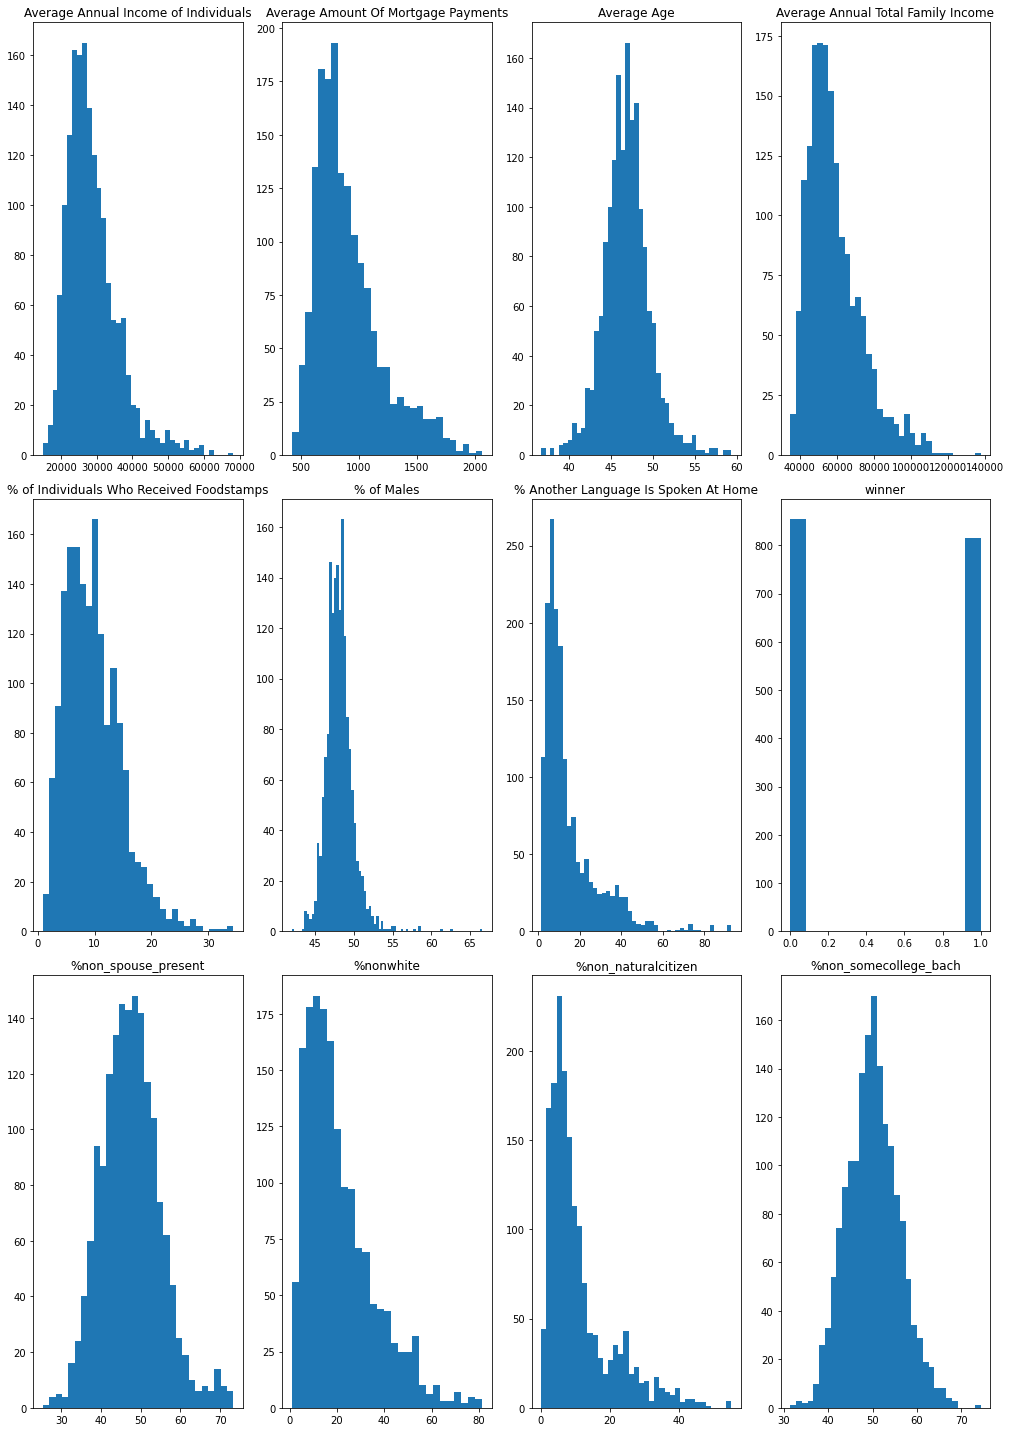

In [72]:
# set up figure for remaining predictor variables in X_third
fig, axes = plt.subplots(nrows=(pres_df_reduced.shape[1] // 4), ncols=4, figsize=(14,20))

# for each col in pres_df_binary, plot distribution
for col, ax in zip(pres_df_reduced, axes.flatten()):
    ax.hist(pres_df_reduced[col], bins='auto')
    ax.set_title(col)
    
fig.tight_layout()

In [73]:
# checking skew
skew_dict_reduced = {col: pres_df_reduced[col].skew() for col in pres_df_reduced.columns}
sorted(skew_dict_reduced.items(), key = lambda x: x[1], reverse = True)

[('% Another Language Is Spoken At Home', 2.1372927643249713),
 ('% of Males', 1.8348877524676177),
 ('%non_naturalcitizen', 1.661418672717671),
 ('Average Annual Income of Individuals', 1.3717823754930822),
 ('Average Annual Total Family Income', 1.2381474444602085),
 ('%nonwhite', 1.2352146871328245),
 ('Average Amount Of Mortgage Payments', 1.1783968298185061),
 ('% of Individuals Who Received Foodstamps', 0.9988343531328995),
 ('%non_spouse_present', 0.4484360326419896),
 ('%not_employed', 0.4029961993206743),
 ('Average Age', 0.3690489370924486),
 ('%non_somecollege_bach', 0.20328171782217846),
 ('winner', 0.04556170203360654)]

In [74]:
pres_df_reduced.describe()

,Average Annual Income of Individuals,Average Amount Of Mortgage Payments,Average Age,Average Annual Total Family Income,% of Individuals Who Received Foodstamps,% of Males,% Another Language Is Spoken At Home,winner,%non_spouse_present,%nonwhite,%non_naturalcitizen,%non_somecollege_bach,%not_employed
count,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000
mean,28841.084850,906.672635,46.903772,58749.243473,9.748743,48.144371,14.897665,0.488623,47.503174,21.264251,11.030240,50.091018,41.774611
std,7295.609512,291.128525,2.787388,14606.621299,4.952513,1.830548,13.393902,0.500020,7.510950,14.650507,9.456712,5.910232,6.556944
min,14897.300000,421.100000,36.700000,34914.700000,0.900000,42.000000,1.400000,0.000000,25.300000,1.000000,0.100000,31.400000,22.600000
25%,23894.650000,698.025000,45.200000,48357.400000,6.100000,47.100000,6.200000,0.000000,42.400000,10.300000,4.700000,46.000000,37.200000
50%,27351.850000,828.550000,46.900000,55458.800000,9.100000,48.000000,10.100000,0.000000,47.150000,17.400000,7.800000,50.000000,41.300000
75%,32176.200000,1039.600000,48.400000,66187.150000,12.700000,49.000000,18.600000,1.000000,52.000000,28.575000,13.600000,53.900000,45.700000
max,68229.100000,2064.600000,59.400000,137573.700000,34.400000,66.600000,93.100000,1.000000,73.300000,81.500000,55.200000,74.400000,69.300000


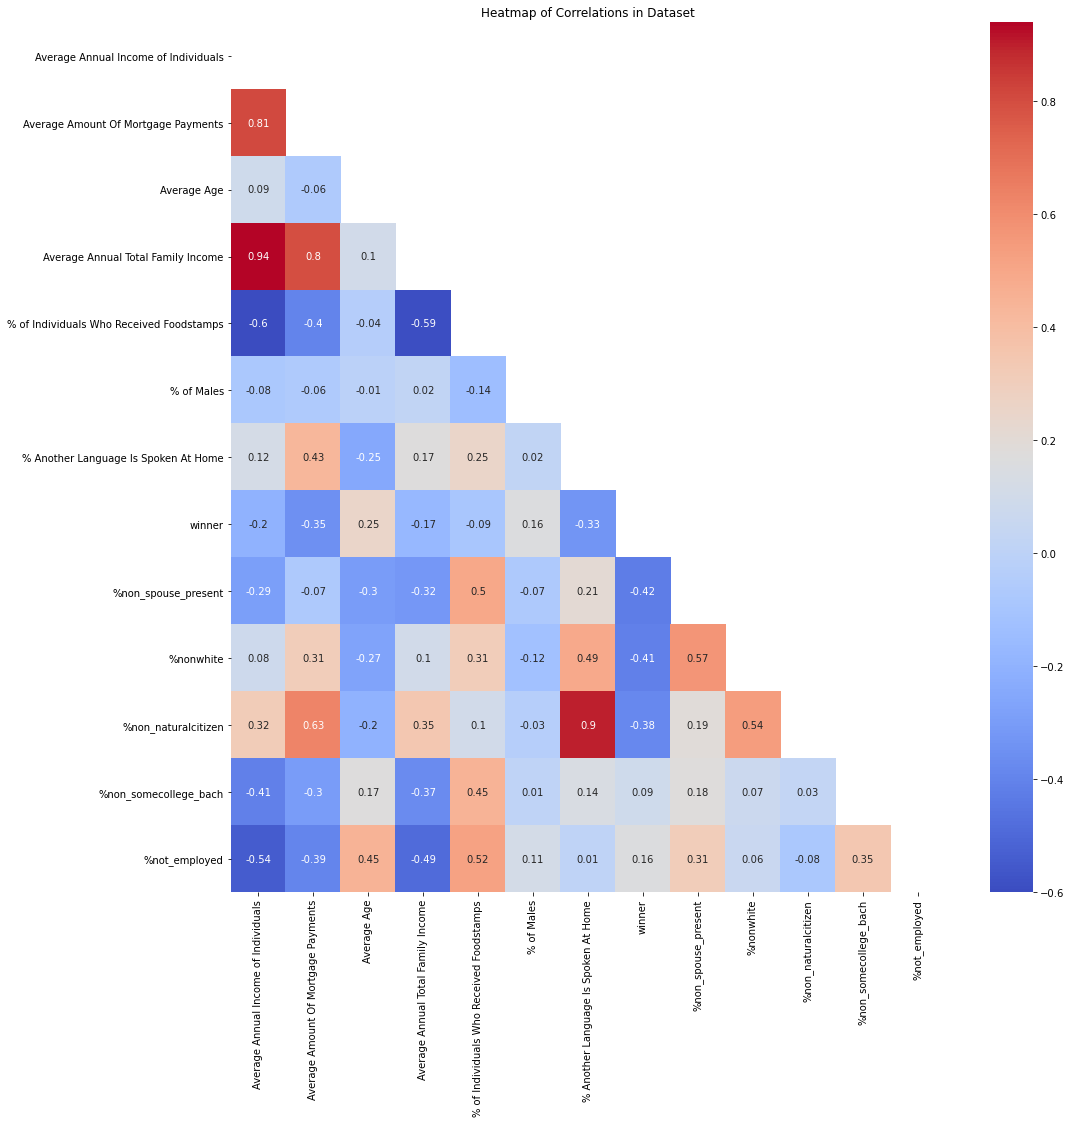

In [75]:
# instantiate figure
fig, ax = plt.subplots(figsize=(16, 16))

# set up correlation matrix
corr = round(pres_df_reduced.corr(), 2)

# create a mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# plot figure
sns.heatmap(corr, cmap = 'coolwarm', annot = True, mask = mask)

# Customize the plot appearance
ax.set_title("Heatmap of Correlations in Dataset");

plt.show()

It looks like reducing the dimensionality of the data also helped to reduce the skew of many of our features, and while there are a few highly correlated variables (% non-natural-citizens and % not english spoken at home, or the income categories and average mortgage amount) we seem to be doing okay there as well. Let's quickly re-run each model with these features to see if it affects their performance.

### Reduced Dimensionality Logistic Regression

In [76]:
# separate X and y
X = pres_df_reduced.drop('winner', axis = 1)
y = pres_df_reduced['winner']

# split into train and test sets with a random state for reproducibility
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 270)

In [77]:
# instantiate pipeline and parameter grid
lr_tuned_decision_reduced = LogisticRegression(penalty = 'l1', solver = 'liblinear', random_state= 42)
lr_tuned_pipe_reduced = Pipeline([('scaler', StandardScaler()), ('model', lr_tuned_decision_reduced)])
lr_tuned_params_reduced = {'model__C': [.1, 1, 10, 100]}
lr_tuned_cv_reduced = GridSearchCV(estimator = lr_tuned_pipe, param_grid = lr_tuned_params, 
                           cv = 5, return_train_score=True)

# fit pipeline
lr_tuned_cv_reduced.fit(X_train_reduced, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(penalty='l1',
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'model__C': [0.1, 1, 10, 100]},
             return_train_score=True)

In [78]:
best_lr_reduced_model = lr_tuned_cv_reduced.best_estimator_
lr_tuned_cv_reduced.best_params_

{'model__C': 10}

In [79]:
# generate predictions
y_lr_tuned_reduced_preds = best_lr_reduced_model.predict(X_test_reduced)

In [80]:
print(classification_report(y_test, y_lr_tuned_reduced_preds))

              precision    recall  f1-score   support

         0.0       0.76      0.74      0.75       221
         1.0       0.71      0.74      0.73       197

    accuracy                           0.74       418
   macro avg       0.74      0.74      0.74       418
weighted avg       0.74      0.74      0.74       418



In [81]:
lr_prec_reduced = precision_score(y_test, y_lr_tuned_reduced_preds)
lr_rec_reduced = recall_score(y_test, y_lr_tuned_reduced_preds)
lr_acc_reduced = accuracy_score(y_test, y_lr_tuned_reduced_preds)
lr_f1_reduced = f1_score(y_test, y_lr_tuned_reduced_preds)

evaluation.loc[4] = ['Tuned Linear Regression - Reduced Data',
                     'C = 10',
                     lr_prec_reduced, lr_rec_reduced, lr_acc_reduced, lr_f1_reduced]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.746341,0.776650,0.770335,0.761194
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547
2,Tuned Random Forest,Max Depth = 4,0.750000,0.791878,0.777512,0.770370
3,Tuned XG Boost,"Estimators = 400, Learning Rate = .01",0.771144,0.786802,0.789474,0.778894
4,Tuned Linear Regression - Reduced Data,C = 10,0.714286,0.736041,0.736842,0.725000


In [82]:
# create dataframe to show coefficients for top 5 most impactful features
lr_reduced_features = pd.DataFrame(zip(X_train_reduced.columns, np.transpose(best_lr_reduced_model[1].coef_)), 
                           columns=['features', 'coef'])
lr_reduced_features.sort_values('coef').head()

,features,coef
7,%non_spouse_present,[-2.031448685592599]
0,Average Annual Income of Individuals,[-1.4358513718696488]
1,Average Amount Of Mortgage Payments,[-0.9697223916643419]
9,%non_naturalcitizen,[-0.5318255408385687]
4,% of Individuals Who Received Foodstamps,[-0.5054654779363701]


### Reduced Dimensionality Random Forest

In [83]:
# instantiate random forest and pipeline
rf_reduced_decision = RandomForestClassifier(n_estimators = 250, random_state= 42, max_depth = 4)
rf_reduced_pipe = Pipeline([('scaler', StandardScaler()),
                    ('model', rf_reduced_decision)])

In [84]:
rf_reduced_pipe.fit(X_train_reduced, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=4, n_estimators=250,
                                        random_state=42))])

In [85]:
y_pred_rf_reduced = rf_reduced_pipe.predict(X_test_reduced)
print(classification_report(y_test, y_pred_rf_reduced))

              precision    recall  f1-score   support

         0.0       0.77      0.78      0.78       221
         1.0       0.75      0.75      0.75       197

    accuracy                           0.76       418
   macro avg       0.76      0.76      0.76       418
weighted avg       0.76      0.76      0.76       418



In [86]:
feat_imp_rf_red = rf_reduced_pipe[1].feature_importances_

feat_imp_series_red = pd.Series(feat_imp_rf_red, 
          index = X_train_reduced.columns).sort_values(
    ascending = False)

feat_imp_series_red

%non_spouse_present                         0.251885
%nonwhite                                   0.184464
%non_naturalcitizen                         0.118448
Average Amount Of Mortgage Payments         0.108857
% Another Language Is Spoken At Home        0.085563
Average Age                                 0.064277
%not_employed                               0.054721
Average Annual Income of Individuals        0.046780
% of Males                                  0.027901
% of Individuals Who Received Foodstamps    0.024439
Average Annual Total Family Income          0.017586
%non_somecollege_bach                       0.015080
dtype: float64

In [87]:
rf_prec_reduced = precision_score(y_test, y_lr_tuned_reduced_preds)
rf_rec_reduced = recall_score(y_test, y_lr_tuned_reduced_preds)
rf_acc_reduced = accuracy_score(y_test, y_lr_tuned_reduced_preds)
rf_f1_reduced = f1_score(y_test, y_lr_tuned_reduced_preds)

evaluation.loc[5] = ['Tuned Random Forest - Reduced Data',
                     'Max Depth = 4',
                     rf_prec_reduced, rf_rec_reduced, rf_acc_reduced, rf_f1_reduced]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.746341,0.776650,0.770335,0.761194
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547
2,Tuned Random Forest,Max Depth = 4,0.750000,0.791878,0.777512,0.770370
3,Tuned XG Boost,"Estimators = 400, Learning Rate = .01",0.771144,0.786802,0.789474,0.778894
4,Tuned Linear Regression - Reduced Data,C = 10,0.714286,0.736041,0.736842,0.725000
5,Tuned Random Forest - Reduced Data,Max Depth = 4,0.714286,0.736041,0.736842,0.725000


### Reduced Dimensionality XGBoost

In [88]:
xg_reduced_params = {'learning_rate': [.01, .1], 'n_estimators': [200,400]}
xg_reduced_cv = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', random_state = 270, 
                                               gamma = 10, max_depth = 3, min_child_weight = 4), 
                     scoring='recall', param_grid = xg_params, cv = 5, return_train_score=True)
xg_reduced_cv.fit(X_train_reduced, y_train);

In [89]:
pd.DataFrame(xg_reduced_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.268350,0.052347,0.002639,0.000607,0.01,200,"{'learning_rate': 0.01, 'n_estimators': 200}",0.806452,0.830645,0.837398,0.814516,0.750000,0.807802,0.030938,4,0.870707,0.866667,0.862903,0.846465,0.850505,0.859449,0.009374
1,0.426147,0.054279,0.002478,0.000426,0.01,400,"{'learning_rate': 0.01, 'n_estimators': 400}",0.806452,0.806452,0.837398,0.830645,0.766129,0.809415,0.025000,3,0.872727,0.866667,0.870968,0.860606,0.848485,0.863891,0.008764
2,0.199346,0.014329,0.001572,0.000237,0.1,200,"{'learning_rate': 0.1, 'n_estimators': 200}",0.822581,0.806452,0.829268,0.822581,0.774194,0.811015,0.019886,1,0.870707,0.868687,0.864919,0.856566,0.856566,0.863489,0.005950
3,0.402785,0.028414,0.001725,0.000198,0.1,400,"{'learning_rate': 0.1, 'n_estimators': 400}",0.822581,0.806452,0.829268,0.822581,0.774194,0.811015,0.019886,1,0.870707,0.868687,0.864919,0.856566,0.856566,0.863489,0.005950


In [90]:
xg_reduced_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=10, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=270,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [91]:
xg_reduced_cv.best_score_

0.8110149488591659

In [92]:
best_xg_model_reduced = xg_reduced_cv.best_estimator_
best_xg_model_reduced.fit(X_train_reduced, y_train)
y_pred_xg_reduced = best_xg_model_reduced.predict(X_test_reduced)

In [93]:
xg_prec_reduced = precision_score(y_test, y_pred_xg_reduced)
xg_rec_reduced = recall_score(y_test, y_pred_xg_reduced)
xg_acc_reduced = accuracy_score(y_test, y_pred_xg_reduced)
xg_f1_reduced = f1_score(y_test, y_pred_xg_reduced)

evaluation.loc[6] = ['Tuned XGBoost - Reduced Data',
                     'Estimators = 200, Learning Rate = .1',
                     xg_prec_reduced, xg_rec_reduced, xg_acc_reduced, xg_f1_reduced]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.746341,0.776650,0.770335,0.761194
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547
2,Tuned Random Forest,Max Depth = 4,0.750000,0.791878,0.777512,0.770370
3,Tuned XG Boost,"Estimators = 400, Learning Rate = .01",0.771144,0.786802,0.789474,0.778894
4,Tuned Linear Regression - Reduced Data,C = 10,0.714286,0.736041,0.736842,0.725000
5,Tuned Random Forest - Reduced Data,Max Depth = 4,0.714286,0.736041,0.736842,0.725000
6,Tuned XGBoost - Reduced Data,"Estimators = 200, Learning Rate = .1",0.733668,0.741117,0.751196,0.737374


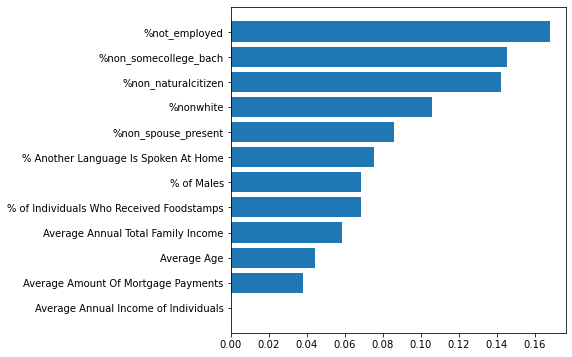

In [94]:
fig, ax = plt.subplots(figsize = (6, 6))
plt.barh(X_train_reduced.columns, sorted(best_xg_model_reduced.feature_importances_));

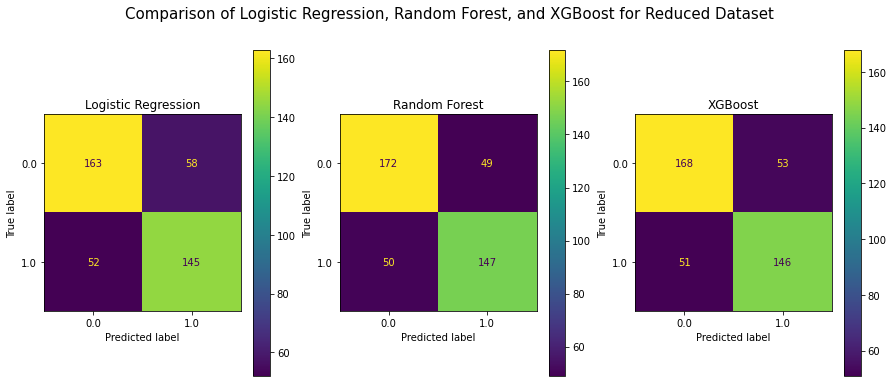

In [95]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

fig.suptitle('Comparison of Logistic Regression, Random Forest, and XGBoost for Reduced Dataset', fontsize = 15)

axes[0].set_title("Logistic Regression")
axes[1].set_title("Random Forest")
axes[2].set_title("XGBoost")

plot_confusion_matrix(best_lr_reduced_model, X_test_reduced, y_test, ax=axes[0])
plot_confusion_matrix(rf_reduced_pipe, X_test_reduced, y_test, ax=axes[1])
plot_confusion_matrix(best_xg_model_reduced, X_test_reduced, y_test, ax=axes[2]);

So it looks like across the board, our models are performing somewhat worse with the reduced dataset. The XGBoost model with the full dataset is still the best model. But with fewer features, we can try one additional approach - a K Nearest Neighbors model.

### Model 5: K Nearest Neighbors

In [96]:
knn_params = {'model__n_neighbors': np.arange(1,12,2), 'model__weights': ['uniform', 'distance']}
knn_pipe = Pipeline([('scaler', StandardScaler()),
                    ('model', KNeighborsClassifier())])
knn_cv = GridSearchCV(estimator = knn_pipe, scoring='recall', 
                      param_grid = knn_params, cv = 5)

knn_cv.fit(X_train_reduced, y_train);

In [97]:
knn_cv.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier())])

In [98]:
knn_cv.best_score_

0.8093627065302911

In [99]:
best_knn_model = knn_cv.best_estimator_
best_knn_model.fit(X_train_reduced, y_train)
y_pred_knn = best_knn_model.predict(X_test_reduced)

In [100]:
knn_prec = precision_score(y_test, y_pred_knn)
knn_rec = recall_score(y_test, y_pred_knn)
knn_acc = accuracy_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)

evaluation.loc[7] = ['K Nearest Neighbors',
                     '# Neighbors = 5',
                     knn_prec, knn_rec, knn_acc, knn_f1]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.746341,0.776650,0.770335,0.761194
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547
2,Tuned Random Forest,Max Depth = 4,0.750000,0.791878,0.777512,0.770370
3,Tuned XG Boost,"Estimators = 400, Learning Rate = .01",0.771144,0.786802,0.789474,0.778894
4,Tuned Linear Regression - Reduced Data,C = 10,0.714286,0.736041,0.736842,0.725000
5,Tuned Random Forest - Reduced Data,Max Depth = 4,0.714286,0.736041,0.736842,0.725000
6,Tuned XGBoost - Reduced Data,"Estimators = 200, Learning Rate = .1",0.733668,0.741117,0.751196,0.737374
7,K Nearest Neighbors,# Neighbors = 5,0.780488,0.812183,0.803828,0.796020


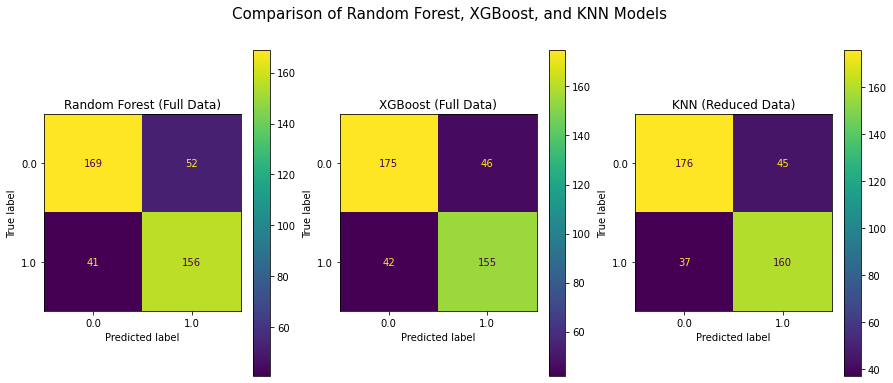

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

fig.suptitle('Comparison of Random Forest, XGBoost, and KNN Models', fontsize = 15)

axes[0].set_title("Random Forest (Full Data)")
axes[1].set_title("XGBoost (Full Data)")
axes[2].set_title("KNN (Reduced Data)")

plot_confusion_matrix(best_rf_model, X_test, y_test, ax=axes[0])
plot_confusion_matrix(best_xg_model, X_test, y_test, ax=axes[1])
plot_confusion_matrix(best_knn_model, X_test_reduced, y_test, ax=axes[2]);

What if we reduce the dimensionality of the data even further by selecting the three variables that appeared in the top five most important for both the reduced random forest and reduced XGBoost?

In [102]:
# define X and y
X_knn = pres_df_reduced[['%nonwhite', '%non_spouse_present', '%non_naturalcitizen']]
y_knn = pres_df_reduced['winner']
                              
# train-test split
X_train_knn, X_test_knn, y_train, y_test = train_test_split(X_knn, y_knn, test_size = .25, random_state = 270)

In [103]:
knn_slim_params = {'model__n_neighbors': np.arange(1,12,2), 'model__weights': ['uniform', 'distance']}
knn_slim_pipe = Pipeline([('scaler', StandardScaler()),
                    ('model', KNeighborsClassifier())])
knn_slim_cv = GridSearchCV(estimator = knn_slim_pipe, scoring='recall', 
                      param_grid = knn_slim_params, cv = 5)

knn_slim_cv.fit(X_train_knn, y_train);

In [104]:
knn_slim_cv.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=11))])

In [105]:
knn_slim_cv.best_score_

0.7528848675583529

In [106]:
best_knn_slim_model = knn_slim_cv.best_estimator_
best_knn_slim_model.fit(X_train_knn, y_train)
y_pred_knn_slim = best_knn_slim_model.predict(X_test_knn)

In [107]:
knn_prec_slim = precision_score(y_test, y_pred_knn_slim)
knn_rec_slim = recall_score(y_test, y_pred_knn_slim)
knn_acc_slim = accuracy_score(y_test, y_pred_knn_slim)
knn_f1_slim = f1_score(y_test, y_pred_knn_slim)

evaluation.loc[8] = ['K Nearest Neighbors - Slim',
                     '# Neighbors = 11',
                     knn_prec_slim, knn_rec_slim, knn_acc_slim, knn_f1_slim]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.746341,0.776650,0.770335,0.761194
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547
2,Tuned Random Forest,Max Depth = 4,0.750000,0.791878,0.777512,0.770370
3,Tuned XG Boost,"Estimators = 400, Learning Rate = .01",0.771144,0.786802,0.789474,0.778894
4,Tuned Linear Regression - Reduced Data,C = 10,0.714286,0.736041,0.736842,0.725000
5,Tuned Random Forest - Reduced Data,Max Depth = 4,0.714286,0.736041,0.736842,0.725000
6,Tuned XGBoost - Reduced Data,"Estimators = 200, Learning Rate = .1",0.733668,0.741117,0.751196,0.737374
7,K Nearest Neighbors,# Neighbors = 5,0.780488,0.812183,0.803828,0.796020
8,K Nearest Neighbors - Slim,# Neighbors = 11,0.678571,0.675127,0.696172,0.676845


This model performed much worse, so we can discard it.

## Model 6: Stacking Model

In [108]:
xgb_pipeline = best_xg_model_reduced

knn_pipeline = best_knn_model

rf_pipeline = rf_reduced_pipe

lr_pipeline = best_lr_reduced_model

# Define the stacking model with a logistic regression meta-model
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_pipeline),
        ('knn', knn_pipeline),
        ('rf', rf_pipeline),
        ('lr', lr_pipeline),
    ],
    final_estimator=LogisticRegression()
)
# Fit the stacking model
stacking_model.fit(X_train_reduced, y_train)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=10,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=4, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=200, n_jobs=0,
                                              num_paral...
                                Pipeline(steps=[('scaler', StandardScaler()),
            

In [109]:
y_pred_stacking = stacking_model.predict(X_test_reduced)

stacking_prec = precision_score(y_test, y_pred_stacking)
stacking_rec = recall_score(y_test, y_pred_stacking)
stacking_acc = accuracy_score(y_test, y_pred_stacking)
stacking_f1 = f1_score(y_test, y_pred_stacking)

evaluation.loc[9] = ['Stacking Model',
                     'Reduced Data, Final Estimator = KNN',
                     stacking_prec, stacking_rec, stacking_acc, stacking_f1]
evaluation

,Model,Details,Accuracy,Recall,Precision,F1
0,Baseline Logistic Regression,-,0.746341,0.776650,0.770335,0.761194
1,Tuned Logistic Regression,C = 10,0.741627,0.786802,0.770335,0.763547
2,Tuned Random Forest,Max Depth = 4,0.750000,0.791878,0.777512,0.770370
3,Tuned XG Boost,"Estimators = 400, Learning Rate = .01",0.771144,0.786802,0.789474,0.778894
4,Tuned Linear Regression - Reduced Data,C = 10,0.714286,0.736041,0.736842,0.725000
5,Tuned Random Forest - Reduced Data,Max Depth = 4,0.714286,0.736041,0.736842,0.725000
6,Tuned XGBoost - Reduced Data,"Estimators = 200, Learning Rate = .1",0.733668,0.741117,0.751196,0.737374
7,K Nearest Neighbors,# Neighbors = 5,0.780488,0.812183,0.803828,0.796020
8,K Nearest Neighbors - Slim,# Neighbors = 11,0.678571,0.675127,0.696172,0.676845
9,Stacking Model,"Reduced Data, Final Estimator = KNN",0.769231,0.761421,0.779904,0.765306


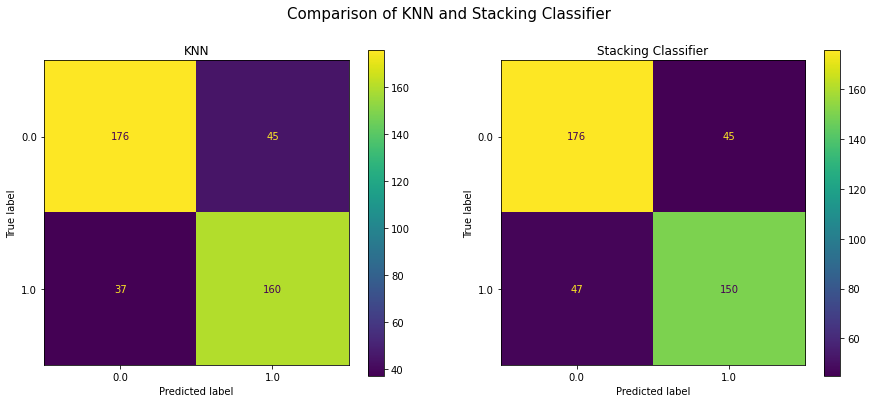

In [110]:
# Plot the confusion matrix
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

fig.suptitle('Comparison of KNN and Stacking Classifier', fontsize = 15)

axes[0].set_title("KNN")
axes[1].set_title("Stacking Classifier")

plot_confusion_matrix(best_knn_model, X_test_reduced, y_test, ax=axes[0])
plot_confusion_matrix(stacking_model, X_test_reduced, y_test, ax=axes[1]);

**After trying numerous approaches, we can say that based on its accuracy and recall scores, the KNN model is the best for our purposes.** This makes sense intuitively - counties with similar demographic characteristics are likely to vote similarly at the presidential level!

## Applying the Model to the Full Dataset

Now that we have a final model, we can apply it to our full dataset to generate predictions for each county and identify where the model is making incorrect predictions.

In [111]:
final_model = best_knn_model

In [112]:
full_train_preds = pd.DataFrame(final_model.predict(X_train_reduced), index = X_train_reduced.index, columns = ['predictions'])
full_test_preds = pd.DataFrame(final_model.predict(X_test_reduced), index = X_test_reduced.index, columns = ['predictions'])
full_preds = pd.concat([full_train_preds, full_test_preds])
full_preds.shape

(1670, 1)

In [113]:
predictions_df = pd.merge(pres_df, full_preds[['predictions']], how='inner', left_index=True, right_index=True)
predictions_df.rename(columns=descriptions_dict, inplace=True)
predictions_df['wrong_prediction'] = 'Correct'
predictions_df.loc[(predictions_df['winner'] == 0) & (predictions_df['predictions'] == 1), 'wrong_prediction'] = 'Dem surprise win'
predictions_df.loc[(predictions_df['winner'] == 1) & (predictions_df['predictions'] == 0), 'wrong_prediction'] = 'Rep surprise win'
predictions_df.groupby('wrong_prediction').mean()

,Year,County FIP Code,Average Annual Income of Individuals,Average Amount Of Mortgage Payments,Average Age,Average Annual Total Family Income,% of Individuals Who Did Not Receive Foodstamps,% of Individuals Who Received Foodstamps,% of Females,% of Males,% Widowed,% Never Married,% Married Spouse Present,% Divorced,% Seperated,% Married Spouse Absent,% White,% Black/African American,% Other Race,% Two major Races,% Japanese,% Other Asian,% American Indian or Alaska Native,% Chinese,% Three or More Races,% Citizen,% Non-Citizen,% Naturalized Citizen,% English Is Spoken At Home,% Another Language Is Spoken At Home,% Some College or Bachelor Degree,% High School or Lower Education,% Masters or Professional Certificate,% Doctoral Degree,% Employed,% Not In The Labor Force,% Unemployed,democrat,green,liberitarian,other,republican,winner,predictions
wrong_prediction,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Correct,2014.252101,28765.293417,29154.821709,919.184244,46.932213,59305.526331,90.314286,9.685714,51.908473,48.091527,6.775560,25.849160,52.527031,11.037255,1.737185,2.073109,78.066667,10.260224,3.042647,3.166176,0.254902,3.192227,0.745448,0.989216,0.286275,88.570658,5.440266,5.989916,84.737325,15.262675,49.905112,38.647339,10.065616,1.381793,58.283123,38.005392,3.711975,122829.383754,182.002801,702.274510,4925.407563,87239.584034,0.493697,0.493697
Dem surprise win,2012.641221,28076.396947,26503.740458,808.261069,47.281679,53865.987786,90.116031,9.883969,51.254198,48.745802,6.940458,24.645802,53.325191,11.601527,1.532824,1.948092,85.877099,6.501527,2.112977,2.333588,0.104580,1.563359,0.939695,0.402290,0.163359,92.648092,3.517557,3.824427,88.974046,11.025954,49.064885,41.483206,8.392366,1.063359,57.497710,38.370992,4.133588,69926.778626,69.022901,463.099237,3042.938931,57234.961832,0.000000,1.000000
Rep surprise win,2015.279279,28855.063063,27563.390090,861.855856,46.091892,57355.861261,89.600000,10.400000,51.885586,48.114414,6.603604,27.089189,51.105405,11.395495,1.739640,2.057658,78.959459,9.544144,3.180180,3.695495,0.143243,2.751351,0.726126,0.773874,0.223423,89.758559,5.133333,5.104505,85.228829,14.771171,50.958559,38.836036,8.958559,1.247748,58.355856,37.927928,3.721622,80986.288288,96.549550,480.702703,5313.891892,99272.864865,1.000000,0.000000


In [114]:
key_cols = ['% of Females',                         # % female
             '% White',                             # % white
             '% Some College or Bachelor Degree ',  # % some college or bachelors degree
             '% Employed',                          # % employed
             'wrong_prediction']

predictions_df_viz = predictions_df[key_cols]
predictions_df_viz.groupby('wrong_prediction').mean()

,% of Females,% White,% Some College or Bachelor Degree,% Employed
wrong_prediction,,,,
Correct,51.908473,78.066667,49.905112,58.283123
Dem surprise win,51.254198,85.877099,49.064885,57.497710
Rep surprise win,51.885586,78.959459,50.958559,58.355856


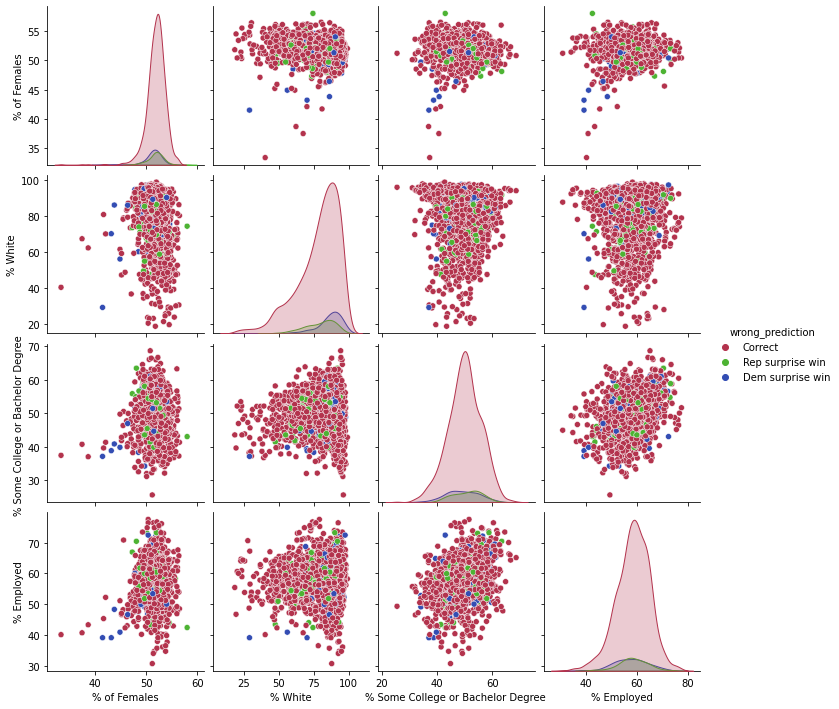

In [115]:
# Define a list of three different colors in RGB format
colors = [(0.7, 0.2, 0.3), (0.3, 0.7, 0.2), (0.2, 0.3, 0.7)]

# Create a custom palette with the chosen colors
custom_palette = sns.color_palette(colors)

sns.pairplot(data = predictions_df_viz, hue = 'wrong_prediction', palette = custom_palette);

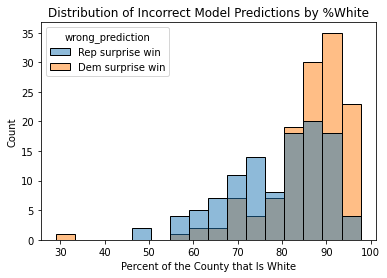

In [116]:
fig, ax = plt.subplots()
sns.histplot(data = predictions_df_viz.loc[predictions_df_viz['wrong_prediction'] != 'Correct'],
                                           x = '% White', hue = 'wrong_prediction')

ax.set_title('Distribution of Incorrect Model Predictions by %White')
ax.set_xlabel('Percent of the County that Is White');